In [1]:
# 🚀 Forex Currency Prediction Analysis

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from prophet import Prophet
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import xgboost as xgb
import joblib
import warnings
import os
from datetime import datetime, timedelta
import time
warnings.filterwarnings('ignore')

print("🎉 Full-Scale Forex Prediction System Initialized!")
print(f"📊 TensorFlow: {tf.__version__}")
print(f"🔮 Prophet: Available")
print(f"📈 XGBoost: Available")
print(f"📊 Training Configuration: ALL CURRENCIES, EXTENDED PERIOD")

🎉 Full-Scale Forex Prediction System Initialized!
📊 TensorFlow: 2.19.0
🔮 Prophet: Available
📈 XGBoost: Available
📊 Training Configuration: ALL CURRENCIES, EXTENDED PERIOD


In [3]:
#Enhanced Configuration for full-scale training
class FullScaleConfig:
    """Configuration for full-scale training"""
    
    # Data parameters
    LOOKBACK_DAYS = 120  # Extended lookback for more features
    TEST_SIZE = 0.15     # Smaller test size to maximize training data
    
    # Model parameters
    TRAIN_ALL_CURRENCIES = True
    MAX_CURRENCIES = None  # No limit - train on all available
    
    # LSTM parameters (enhanced for longer sequences)
    LSTM_LOOKBACK = 90   # 3 months of data for LSTM
    LSTM_EPOCHS = 150    # More epochs for complex patterns
    LSTM_BATCH_SIZE = 64 # Larger batch size for stability
    
    # Feature engineering
    ROLLING_WINDOWS = [5, 10, 20, 30, 60, 90, 120]  # Extended windows
    TECHNICAL_INDICATORS = True
    ADVANCED_FEATURES = True
    
    # Performance optimization
    USE_MULTIPROCESSING = True
    EARLY_STOPPING_PATIENCE = 20
    
    # Output settings
    SAVE_ALL_MODELS = True
    CREATE_DETAILED_REPORTS = True
    GENERATE_FORECASTS = True

config = FullScaleConfig()

In [4]:
#Data Loading
def load_complete_forex_data():
    """Load the complete forex dataset with minimal processing"""
    print("📊 Loading complete forex dataset...")
    
    data_files = [
        "Foreign_Exchange_Rates.xls",
        "data/Foreign_Exchange_Rates.xls",
        "../Foreign_Exchange_Rates.xls"
    ]
    
    for file_path in data_files:
        try:
            print(f"📂 Attempting to load: {file_path}")
            
            # Try different file formats
            if file_path.endswith('.xls') or file_path.endswith('.xlsx'):
                try:
                    data = pd.read_excel(file_path)
                except:
                    data = pd.read_csv(file_path)  # Sometimes .xls files are actually CSV
            else:
                data = pd.read_csv(file_path)
            
            # Clean up columns
            data = data.drop([col for col in data.columns if 'Unnamed' in str(col) or col.startswith('_')], axis=1)
            
            # Find and process date column
            date_col = None
            for col in data.columns:
                if any(word in col.lower() for word in ['time', 'date', 'serie']):
                    date_col = col
                    break
            
            if date_col:
                # Try multiple date formats
                for fmt in ['%d-%m-%Y', '%Y-%m-%d', '%m/%d/%Y']:
                    try:
                        data[date_col] = pd.to_datetime(data[date_col], format=fmt)
                        break
                    except:
                        continue
                
                # If no format worked, try auto-parsing
                if data[date_col].dtype == 'object':
                    data[date_col] = pd.to_datetime(data[date_col], errors='coerce')
                
                data = data.rename(columns={date_col: 'Date'})
                data.set_index('Date', inplace=True)
                data = data.sort_index()
            
            # Convert all columns to numeric
            for col in data.columns:
                data[col] = pd.to_numeric(data[col], errors='coerce')
            
            # Remove any rows with all NaN values
            data = data.dropna(how='all')
            
            print(f"✅ Successfully loaded complete dataset!")
            print(f"📊 Shape: {data.shape}")
            print(f"📅 Date range: {data.index.min()} to {data.index.max()}")
            print(f"💱 Total currencies: {len(data.columns)}")
            print(f"📈 Total data points: {data.count().sum():,}")
            
            return data
            
        except Exception as e:
            print(f"❌ Failed to load {file_path}: {str(e)}")
            continue
    
    print("❌ Could not load data from any location")
    return create_comprehensive_sample_data()

def create_comprehensive_sample_data():
    """Create comprehensive sample data if real data unavailable"""
    print("💡 Creating comprehensive sample dataset...")
    
    np.random.seed(42)
    # Extended date range - 25 years of data
    dates = pd.date_range('2000-01-01', '2024-12-31', freq='D')
    
    # All major currency pairs with realistic parameters
    currencies = {
        'EURO AREA - EURO/US$': {'start': 1.18, 'volatility': 0.008, 'trend': 0.0001},
        'UNITED KINGDOM - UNITED KINGDOM POUND/US$': {'start': 1.28, 'volatility': 0.012, 'trend': -0.0001},
        'JAPAN - YEN/US$': {'start': 110.0, 'volatility': 0.8, 'trend': 0.02},
        'CANADA - CANADIAN DOLLAR/US$': {'start': 1.33, 'volatility': 0.006, 'trend': 0.00005},
        'AUSTRALIA - AUSTRALIAN DOLLAR/US$': {'start': 0.72, 'volatility': 0.010, 'trend': -0.00003},
        'SWITZERLAND - FRANC/US$': {'start': 0.92, 'volatility': 0.007, 'trend': -0.00002},
        'CHINA - YUAN/US$': {'start': 6.45, 'volatility': 0.015, 'trend': 0.0003},
        'INDIA - INDIAN RUPEE/US$': {'start': 74.0, 'volatility': 0.3, 'trend': 0.01},
        'BRAZIL - REAL/US$': {'start': 5.2, 'volatility': 0.05, 'trend': 0.001},
        'SOUTH AFRICA - RAND/US$': {'start': 14.5, 'volatility': 0.15, 'trend': 0.002},
        'MEXICO - MEXICAN PESO/US$': {'start': 9.5, 'volatility': 0.08, 'trend': 0.0008},
        'KOREA - WON/US$': {'start': 1200, 'volatility': 8, 'trend': 0.05},
        'SINGAPORE - SINGAPORE DOLLAR/US$': {'start': 1.35, 'volatility': 0.005, 'trend': 0.00001},
        'HONG KONG - HONG KONG DOLLAR/US$': {'start': 7.75, 'volatility': 0.002, 'trend': 0.0001},
        'NORWAY - NORWEGIAN KRONE/US$': {'start': 8.5, 'volatility': 0.012, 'trend': 0.0002},
        'SWEDEN - KRONA/US$': {'start': 9.2, 'volatility': 0.011, 'trend': 0.0001},
        'DENMARK - DANISH KRONE/US$': {'start': 6.8, 'volatility': 0.008, 'trend': 0.00005},
        'THAILAND - BAHT/US$': {'start': 36.0, 'volatility': 0.4, 'trend': 0.005},
        'MALAYSIA - RINGGIT/US$': {'start': 4.2, 'volatility': 0.03, 'trend': 0.0003},
        'TAIWAN - NEW TAIWAN DOLLAR/US$': {'start': 31.0, 'volatility': 0.25, 'trend': 0.002},
        'SRI LANKA - SRI LANKAN RUPEE/US$': {'start': 190, 'volatility': 2.5, 'trend': 0.05}
    }
    
    data = pd.DataFrame(index=dates)
    
    for currency, params in currencies.items():
        n_days = len(dates)
        
        # Create realistic time series with multiple components
        
        # 1. Trend component
        trend = np.linspace(0, params['trend'] * n_days, n_days)
        
        # 2. Seasonal components
        annual_seasonal = 0.02 * np.sin(2 * np.pi * np.arange(n_days) / 365.25)
        monthly_seasonal = 0.01 * np.sin(2 * np.pi * np.arange(n_days) / 30.44)
        
        # 3. Economic cycle (7-year cycle)
        economic_cycle = 0.03 * np.sin(2 * np.pi * np.arange(n_days) / (365.25 * 7))
        
        # 4. Random walk with volatility clustering
        returns = np.random.normal(0, params['volatility'], n_days)
        
        # Add volatility clustering (GARCH-like effect)
        volatility = np.ones(n_days) * params['volatility']
        for i in range(1, n_days):
            volatility[i] = 0.95 * volatility[i-1] + 0.05 * abs(returns[i-1])
            returns[i] = np.random.normal(0, volatility[i])
        
        # 5. Occasional jumps (crisis events)
        jump_probability = 0.001  # 0.1% chance per day
        jumps = np.random.binomial(1, jump_probability, n_days)
        jump_sizes = np.random.normal(0, params['volatility'] * 5, n_days) * jumps
        
        # Combine all components
        log_prices = (trend + annual_seasonal + monthly_seasonal + 
                     economic_cycle + np.cumsum(returns) + np.cumsum(jump_sizes))
        
        prices = params['start'] * np.exp(log_prices)
        data[currency] = prices
    
    print(f"✅ Comprehensive sample data created!")
    print(f"📊 Shape: {data.shape}")
    print(f"💱 Currencies: {len(data.columns)}")
    
    return data

# Load the complete dataset
forex_data = load_complete_forex_data()

📊 Loading complete forex dataset...
📂 Attempting to load: Foreign_Exchange_Rates.xls
✅ Successfully loaded complete dataset!
📊 Shape: (5020, 22)
📅 Date range: 2000-01-03 00:00:00 to 2019-12-31 00:00:00
💱 Total currencies: 22
📈 Total data points: 110,415


In [7]:
#Feature Engineering
def create_comprehensive_features(data, target_col, lookback_days=120):
    """Create comprehensive feature set with extended lookback"""
    print(f"🔧 Creating comprehensive features for {target_col}...")
    print(f"   📊 Lookback period: {lookback_days} days")
    
    df = data[[target_col]].copy()
    original_length = len(df)
    
    # 1. Extended lag features
    lag_periods = [1, 2, 3, 5, 7, 10, 14, 21, 30, 45, 60, 90]
    for lag in lag_periods:
        if lag <= lookback_days:
            df[f'lag_{lag}'] = df[target_col].shift(lag)
    
    # 2. Comprehensive rolling statistics
    for window in config.ROLLING_WINDOWS:
        if len(df) > window:
            df[f'rolling_mean_{window}'] = df[target_col].rolling(window).mean()
            df[f'rolling_std_{window}'] = df[target_col].rolling(window).std()
            df[f'rolling_max_{window}'] = df[target_col].rolling(window).max()
            df[f'rolling_min_{window}'] = df[target_col].rolling(window).min()
            df[f'rolling_median_{window}'] = df[target_col].rolling(window).median()
            df[f'rolling_skew_{window}'] = df[target_col].rolling(window).skew()
            df[f'rolling_kurt_{window}'] = df[target_col].rolling(window).kurt()
    
    # 3. Advanced technical indicators
    if config.TECHNICAL_INDICATORS and len(df) > 50:
        # Moving averages
        ma_periods = [5, 10, 20, 50, 100, 200]
        for period in ma_periods:
            if len(df) > period:
                df[f'sma_{period}'] = df[target_col].rolling(period).mean()
                df[f'ema_{period}'] = df[target_col].ewm(span=period).mean()
        
        # MACD with multiple settings
        if len(df) > 26:
            for fast, slow, signal in [(12, 26, 9), (8, 21, 5), (19, 39, 9)]:
                ema_fast = df[target_col].ewm(span=fast).mean()
                ema_slow = df[target_col].ewm(span=slow).mean()
                macd = ema_fast - ema_slow
                macd_signal = macd.ewm(span=signal).mean()
                
                df[f'macd_{fast}_{slow}'] = macd
                df[f'macd_signal_{fast}_{slow}_{signal}'] = macd_signal
                df[f'macd_histogram_{fast}_{slow}_{signal}'] = macd - macd_signal
        
        # RSI with multiple periods
        for rsi_period in [14, 21, 30]:
            if len(df) > rsi_period:
                delta = df[target_col].diff()
                gain = (delta.where(delta > 0, 0)).rolling(window=rsi_period).mean()
                loss = (-delta.where(delta < 0, 0)).rolling(window=rsi_period).mean()
                rs = gain / loss
                df[f'rsi_{rsi_period}'] = 100 - (100 / (1 + rs))
        
        # Bollinger Bands with multiple settings
        for bb_period, bb_std in [(20, 2), (10, 1.5), (50, 2.5)]:
            if len(df) > bb_period:
                bb_middle = df[target_col].rolling(bb_period).mean()
                bb_std_dev = df[target_col].rolling(bb_period).std()
                bb_upper = bb_middle + (bb_std_dev * bb_std)
                bb_lower = bb_middle - (bb_std_dev * bb_std)
                
                df[f'bb_middle_{bb_period}'] = bb_middle
                df[f'bb_upper_{bb_period}_{bb_std}'] = bb_upper
                df[f'bb_lower_{bb_period}_{bb_std}'] = bb_lower
                df[f'bb_width_{bb_period}_{bb_std}'] = bb_upper - bb_lower
                df[f'bb_position_{bb_period}_{bb_std}'] = (df[target_col] - bb_lower) / (bb_upper - bb_lower)
        
        # Stochastic Oscillator
        if len(df) > 14:
            for k_period, d_period in [(14, 3), (21, 5)]:
                if len(df) > k_period:
                    lowest_low = df[target_col].rolling(k_period).min()
                    highest_high = df[target_col].rolling(k_period).max()
                    k_percent = 100 * ((df[target_col] - lowest_low) / (highest_high - lowest_low))
                    d_percent = k_percent.rolling(d_period).mean()
                    
                    df[f'stoch_k_{k_period}'] = k_percent
                    df[f'stoch_d_{k_period}_{d_period}'] = d_percent
        
        # Williams %R
        if len(df) > 14:
            for wr_period in [14, 21]:
                if len(df) > wr_period:
                    highest_high = df[target_col].rolling(wr_period).max()
                    lowest_low = df[target_col].rolling(wr_period).min()
                    df[f'williams_r_{wr_period}'] = -100 * ((highest_high - df[target_col]) / (highest_high - lowest_low))
    
    # 4. Price-based features with multiple timeframes
    price_change_periods = [1, 2, 3, 5, 7, 14, 21, 30, 60, 90]
    for period in price_change_periods:
        if period <= lookback_days:
            df[f'price_change_{period}d'] = df[target_col].pct_change(period)
            df[f'price_diff_{period}d'] = df[target_col].diff(period)
    
    # 5. Volatility features
    for vol_window in [5, 10, 20, 30, 60]:
        if len(df) > vol_window:
            returns = df[target_col].pct_change()
            df[f'volatility_{vol_window}d'] = returns.rolling(vol_window).std() * np.sqrt(252)
            df[f'realized_vol_{vol_window}d'] = returns.rolling(vol_window).apply(lambda x: np.sqrt(np.sum(x**2)))
    
    # 6. Advanced statistical features
    if config.ADVANCED_FEATURES:
        for window in [20, 60, 120]:
            if len(df) > window:
                returns = df[target_col].pct_change()
                
                # Higher moments
                df[f'skewness_{window}d'] = returns.rolling(window).skew()
                df[f'kurtosis_{window}d'] = returns.rolling(window).kurt()
                
                # Autocorrelation
                df[f'autocorr_1_{window}d'] = returns.rolling(window).apply(lambda x: x.autocorr(lag=1))
                df[f'autocorr_5_{window}d'] = returns.rolling(window).apply(lambda x: x.autocorr(lag=5))
                
                # Trend strength
                df[f'trend_strength_{window}d'] = df[target_col].rolling(window).apply(
                    lambda x: np.corrcoef(np.arange(len(x)), x)[0, 1] if len(x) > 1 else 0
                )
    
    # 7. Cross-currency features (if other currencies available)
    other_currencies = [col for col in data.columns if col != target_col][:3]  # Top 3 others
    for other_curr in other_currencies:
        if other_curr in data.columns:
            # Currency correlations
            for window in [30, 60, 120]:
                if len(df) > window:
                    df[f'corr_{other_curr.split()[0]}_{window}d'] = df[target_col].rolling(window).corr(data[other_curr])
            
            # Relative strength
            df[f'relative_strength_{other_curr.split()[0]}'] = df[target_col] / data[other_curr]
    
    # 8. Enhanced date and time features
    df['day'] = df.index.day
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['day_of_week'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['week_of_year'] = df.index.isocalendar().week
    df['is_month_start'] = df.index.is_month_start.astype(int)
    df['is_month_end'] = df.index.is_month_end.astype(int)
    df['is_quarter_start'] = df.index.is_quarter_start.astype(int)
    df['is_quarter_end'] = df.index.is_quarter_end.astype(int)
    df['is_year_start'] = df.index.is_year_start.astype(int)
    df['is_year_end'] = df.index.is_year_end.astype(int)
    
    # 9. Cyclical encoding for better ML performance
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    df['quarter_sin'] = np.sin(2 * np.pi * df['quarter'] / 4)
    df['quarter_cos'] = np.cos(2 * np.pi * df['quarter'] / 4)
    
    # 10. Economic calendar features (simplified)
    # Add day-of-week and month patterns that might reflect economic announcements
    df['is_friday'] = (df['day_of_week'] == 4).astype(int)  # NFP day
    df['is_first_week'] = (df.index.day <= 7).astype(int)   # Common for central bank meetings
    
    # Remove rows with NaN values
    df_clean = df.dropna()
    
    print(f"✅ Comprehensive feature engineering completed!")
    print(f"   📊 Original length: {original_length:,}")
    print(f"   📊 After cleaning: {len(df_clean):,}")
    print(f"   🔧 Total features: {len(df_clean.columns) - 1}")
    print(f"   📉 Data reduction: {((original_length - len(df_clean)) / original_length * 100):.1f}%")
    
    return df_clean

In [8]:
# Test feature engineering on one currency first
test_currency = forex_data.columns[0]  # First currency in your dataset
print(f"🧪 Testing feature engineering on: {test_currency}")

# Run feature engineering for this currency
test_features = create_comprehensive_features(forex_data, test_currency, lookback_days=120)

print(f"\n📊 Feature Engineering Results:")
print(f"   Original data: {len(forex_data)} rows")
print(f"   After features: {len(test_features)} rows")
print(f"   Total features: {len(test_features.columns) - 1}")
print(f"   Feature list (first 10):")
for i, col in enumerate(list(test_features.columns)[:10], 1):
    if col != test_currency:
        print(f"     {i}. {col}")

🧪 Testing feature engineering on: AUSTRALIA - AUSTRALIAN DOLLAR/US$
🔧 Creating comprehensive features for AUSTRALIA - AUSTRALIAN DOLLAR/US$...
   📊 Lookback period: 120 days
✅ Comprehensive feature engineering completed!
   📊 Original length: 5,020
   📊 After cleaning: 4,621
   🔧 Total features: 183
   📉 Data reduction: 7.9%

📊 Feature Engineering Results:
   Original data: 5020 rows
   After features: 4621 rows
   Total features: 183
   Feature list (first 10):
     2. lag_1
     3. lag_2
     4. lag_3
     5. lag_5
     6. lag_7
     7. lag_10
     8. lag_14
     9. lag_21
     10. lag_30


In [9]:
#Model Training
class FullScaleForexPredictor:
    """Enhanced forex predictor for full-scale training across all currencies"""
    
    def __init__(self, target_col):
        self.target_col = target_col
        self.models = {}
        self.scalers = {}
        self.results = {}
        self.training_time = {}
        
    def prepare_data_advanced(self, df, test_size=0.15):
        """Advanced data preparation with validation split"""
        print(f"📊 Preparing advanced dataset for {self.target_col}...")
        
        # Ensure chronological order
        df_sorted = df.sort_index()
        X = df_sorted.drop(columns=[self.target_col])
        y = df_sorted[self.target_col]
        
        # Create train/validation/test splits
        n_samples = len(df_sorted)
        train_end = int(n_samples * (1 - test_size - 0.1))  # 75% train
        val_end = int(n_samples * (1 - test_size))          # 10% validation
        
        X_train = X.iloc[:train_end]
        X_val = X.iloc[train_end:val_end]
        X_test = X.iloc[val_end:]
        
        y_train = y.iloc[:train_end]
        y_val = y.iloc[train_end:val_end]
        y_test = y.iloc[val_end:]
        
        print(f"✅ Advanced data split completed:")
        print(f"   📈 Training: {X_train.shape} ({train_end/n_samples:.1%})")
        print(f"   📊 Validation: {X_val.shape} ({(val_end-train_end)/n_samples:.1%})")
        print(f"   🎯 Test: {X_test.shape} ({(n_samples-val_end)/n_samples:.1%})")
        print(f"   📅 Train period: {X_train.index.min()} to {X_train.index.max()}")
        print(f"   📅 Test period: {X_test.index.min()} to {X_test.index.max()}")
        
        return X_train, X_val, X_test, y_train, y_val, y_test
    
    def train_enhanced_traditional_models(self, X_train, X_val, X_test, y_train, y_val, y_test):
        """Train enhanced traditional ML models with hyperparameter optimization"""
        print("🤖 Training enhanced traditional ML models...")
        
        # Prepare scaled features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        X_test_scaled = scaler.transform(X_test)
        self.scalers['traditional'] = scaler
        
        models_config = {
            'Linear Regression': {
                'model': LinearRegression(),
                'use_scaling': True
            },
            'Random Forest': {
                'model': RandomForestRegressor(
                    n_estimators=500,        # More trees
                    max_depth=20,            # Deeper trees
                    min_samples_split=5,
                    min_samples_leaf=2,
                    max_features='sqrt',
                    bootstrap=True,
                    random_state=42,
                    n_jobs=-1 if config.USE_MULTIPROCESSING else 1
                ),
                'use_scaling': False
            },
            'XGBoost': {
                'model': xgb.XGBRegressor(
                    n_estimators=1000,       # More estimators
                    max_depth=10,            # Deeper trees
                    learning_rate=0.05,      # Lower learning rate
                    subsample=0.8,
                    colsample_bytree=0.8,
                    colsample_bylevel=0.8,
                    reg_alpha=0.1,           # L1 regularization
                    reg_lambda=1.0,          # L2 regularization
                    random_state=42,
                    verbosity=0,
                    n_jobs=-1 if config.USE_MULTIPROCESSING else 1,
                    early_stopping_rounds=50
                ),
                'use_scaling': False,
                'use_validation': True
            }
        }
        
        for name, config_dict in models_config.items():
            print(f"  📈 Training {name}...")
            start_time = time.time()
            
            try:
                model = config_dict['model']
                
                if config_dict['use_scaling']:
                    if config_dict.get('use_validation'):
                        model.fit(X_train_scaled, y_train, 
                                eval_set=[(X_val_scaled, y_val)], 
                                verbose=False)
                    else:
                        model.fit(X_train_scaled, y_train)
                    y_pred = model.predict(X_test_scaled)
                else:
                    if config_dict.get('use_validation'):
                        model.fit(X_train, y_train, 
                                eval_set=[(X_val, y_val)], 
                                verbose=False)
                    else:
                        model.fit(X_train, y_train)
                    y_pred = model.predict(X_test)
                
                # Calculate comprehensive metrics
                mae = mean_absolute_error(y_test, y_pred)
                rmse = np.sqrt(mean_squared_error(y_test, y_pred))
                mape = mean_absolute_percentage_error(y_test, y_pred) * 100
                r2 = 1 - (np.sum((y_test - y_pred) ** 2) / np.sum((y_test - y_test.mean()) ** 2))
                max_error = np.max(np.abs(y_test - y_pred))
                
                training_time = time.time() - start_time
                
                self.models[name] = model
                self.training_time[name] = training_time
                self.results[name] = {
                    'MAE': mae,
                    'RMSE': rmse,
                    'MAPE': mape,
                    'R2': r2,
                    'Max_Error': max_error,
                    'Training_Time': training_time,
                    'predictions': y_pred,
                    'use_scaling': config_dict['use_scaling']
                }
                
                print(f"    ✅ {name} - Time: {training_time:.1f}s")
                print(f"       MAE: {mae:.4f} | RMSE: {rmse:.4f} | MAPE: {mape:.2f}% | R²: {r2:.3f}")
                
            except Exception as e:
                print(f"    ❌ {name} failed: {str(e)}")
    
    def train_advanced_lstm_model(self, df, X_train, X_val, X_test, y_train, y_val, y_test):
        """Train advanced LSTM with sophisticated architecture"""
        print("🧠 Training advanced LSTM model...")
        start_time = time.time()
        
        try:
            # Prepare LSTM-specific data with extended lookback
            scaler = MinMaxScaler(feature_range=(0, 1))
            target_data = df[[self.target_col]].values
            scaled_data = scaler.fit_transform(target_data)
            self.scalers['lstm'] = scaler
            
             # Prepare LSTM-specific data with extended lookback
            scaler = MinMaxScaler(feature_range=(0, 1))
            target_data = df[[self.target_col]].values
            scaled_data = scaler.fit_transform(target_data)
            self.scalers['lstm'] = scaler
            
            # Create sequences with extended lookback
            lookback = min(config.LSTM_LOOKBACK, len(scaled_data) // 4)
            X_lstm, y_lstm = [], []
            
            for i in range(lookback, len(scaled_data)):
                X_lstm.append(scaled_data[i-lookback:i, 0])
                y_lstm.append(scaled_data[i, 0])
            
            X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)
            
            # Create train/val/test splits for LSTM
            n_samples = len(X_lstm)
            train_end = int(n_samples * 0.75)
            val_end = int(n_samples * 0.85)
            
            X_lstm_train = X_lstm[:train_end]
            X_lstm_val = X_lstm[train_end:val_end]
            X_lstm_test = X_lstm[val_end:]
            
            y_lstm_train = y_lstm[:train_end]
            y_lstm_val = y_lstm[train_end:val_end]
            y_lstm_test = y_lstm[val_end:]
            
            # Reshape for LSTM [samples, time steps, features]
            X_lstm_train = X_lstm_train.reshape((X_lstm_train.shape[0], X_lstm_train.shape[1], 1))
            X_lstm_val = X_lstm_val.reshape((X_lstm_val.shape[0], X_lstm_val.shape[1], 1))
            X_lstm_test = X_lstm_test.reshape((X_lstm_test.shape[0], X_lstm_test.shape[1], 1))
            
            # Build advanced LSTM architecture
            model = Sequential([
                # First LSTM layer with return sequences
                LSTM(128, return_sequences=True, input_shape=(X_lstm_train.shape[1], 1)),
                BatchNormalization(),
                Dropout(0.3),
                
                # Second LSTM layer with return sequences
                LSTM(128, return_sequences=True),
                BatchNormalization(),
                Dropout(0.3),
                
                # Third LSTM layer without return sequences
                LSTM(64, return_sequences=False),
                BatchNormalization(),
                Dropout(0.3),
                
                # Dense layers with regularization
                Dense(64, activation='relu'),
                BatchNormalization(),
                Dropout(0.2),
                
                Dense(32, activation='relu'),
                Dropout(0.2),
                
                Dense(16, activation='relu'),
                Dense(1)
            ])
            
            # Compile with advanced optimizer settings
            optimizer = Adam(
                learning_rate=0.001,
                beta_1=0.9,
                beta_2=0.999,
                epsilon=1e-7,
                clipnorm=1.0  # Gradient clipping
            )
            
            model.compile(
                optimizer=optimizer,
                loss='huber',  # Robust to outliers
                metrics=['mae', 'mse']
            )
            
            # Advanced callbacks
            callbacks = [
                EarlyStopping(
                    monitor='val_loss',
                    patience=config.EARLY_STOPPING_PATIENCE,
                    restore_best_weights=True,
                    verbose=0
                ),
                ReduceLROnPlateau(
                    monitor='val_loss',
                    factor=0.5,
                    patience=10,
                    min_lr=1e-7,
                    verbose=0
                ),
                ModelCheckpoint(
                    'temp_lstm_model.h5',
                    monitor='val_loss',
                    save_best_only=True,
                    verbose=0
                )
            ]
            
            # Train the model
            print(f"    🔄 Training LSTM with {X_lstm_train.shape[0]:,} samples...")
            history = model.fit(
                X_lstm_train, y_lstm_train,
                batch_size=config.LSTM_BATCH_SIZE,
                epochs=config.LSTM_EPOCHS,
                validation_data=(X_lstm_val, y_lstm_val),
                callbacks=callbacks,
                verbose=0
            )
            
            # Load best model
            model.load_weights('temp_lstm_model.h5')
            
            # Make predictions
            y_pred_scaled = model.predict(X_lstm_test, verbose=0)
            
            # Inverse transform predictions
            y_test_actual = scaler.inverse_transform(y_lstm_test.reshape(-1, 1)).flatten()
            y_pred_actual = scaler.inverse_transform(y_pred_scaled).flatten()
            
            # Calculate metrics
            mae = mean_absolute_error(y_test_actual, y_pred_actual)
            rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
            mape = mean_absolute_percentage_error(y_test_actual, y_pred_actual) * 100
            r2 = 1 - (np.sum((y_test_actual - y_pred_actual) ** 2) / np.sum((y_test_actual - y_test_actual.mean()) ** 2))
            
            training_time = time.time() - start_time
            
            self.models['LSTM'] = model
            self.training_time['LSTM'] = training_time
            self.results['LSTM'] = {
                'MAE': mae,
                'RMSE': rmse,
                'MAPE': mape,
                'R2': r2,
                'Max_Error': np.max(np.abs(y_test_actual - y_pred_actual)),
                'Training_Time': training_time,
                'predictions': y_pred_actual,
                'actual': y_test_actual,
                'history': history,
                'lookback': lookback
            }
            
            print(f"    ✅ LSTM - Time: {training_time:.1f}s")
            print(f"       MAE: {mae:.4f} | RMSE: {rmse:.4f} | MAPE: {mape:.2f}% | R²: {r2:.3f}")
            
            # Clean up temporary file
            if os.path.exists('temp_lstm_model.h5'):
                os.remove('temp_lstm_model.h5')
                
        except Exception as e:
            print(f"    ❌ LSTM failed: {str(e)}")
            import traceback
            traceback.print_exc()
    
    def train_advanced_prophet_model(self, df):
        """Train Prophet with comprehensive configuration"""
        print("🔮 Training advanced Prophet model...")
        start_time = time.time()
        
        try:
            # Prepare Prophet data
            prophet_df = df[[self.target_col]].reset_index()
            prophet_df.columns = ['ds', 'y']
            
            # Remove any infinite or extremely large values
            prophet_df = prophet_df.replace([np.inf, -np.inf], np.nan).dropna()
            
            # Time series split for Prophet
            split_idx = int(len(prophet_df) * 0.85)
            train_df = prophet_df[:split_idx]
            test_df = prophet_df[split_idx:]
            
            # Configure advanced Prophet model
            model = Prophet(
                growth='linear',
                yearly_seasonality=True,
                weekly_seasonality=True,
                daily_seasonality=False,
                seasonality_mode='additive',
                changepoint_prior_scale=0.05,
                seasonality_prior_scale=10,
                holidays_prior_scale=10,
                changepoint_range=0.8,
                interval_width=0.95,
                mcmc_samples=0,  # Use MAP estimation for speed
                uncertainty_samples=1000
            )
            
            # Add custom seasonalities for forex markets
            model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
            model.add_seasonality(name='quarterly', period=91.25, fourier_order=8)
            model.add_seasonality(name='semi_annual', period=182.5, fourier_order=4)
            
            # Add country-specific holidays if available
            # Note: This is simplified - in production, you'd add actual forex market holidays
            
            # Fit model with suppressed warnings
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                model.fit(train_df)
            
            # Create future dataframe
            future = model.make_future_dataframe(periods=len(test_df))
            
            # Generate forecast
            forecast = model.predict(future)
            
            # Extract test predictions
            y_pred = forecast['yhat'].iloc[-len(test_df):].values
            y_test = test_df['y'].values
            
            # Calculate metrics
            mae = mean_absolute_error(y_test, y_pred)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            mape = mean_absolute_percentage_error(y_test, y_pred) * 100
            r2 = 1 - (np.sum((y_test - y_pred) ** 2) / np.sum((y_test - y_test.mean()) ** 2))
            
            training_time = time.time() - start_time
            
            self.models['Prophet'] = model
            self.training_time['Prophet'] = training_time
            self.results['Prophet'] = {
                'MAE': mae,
                'RMSE': rmse,
                'MAPE': mape,
                'R2': r2,
                'Max_Error': np.max(np.abs(y_test - y_pred)),
                'Training_Time': training_time,
                'predictions': y_pred,
                'actual': y_test,
                'forecast': forecast,
                'train_size': len(train_df),
                'test_size': len(test_df)
            }
            
            print(f"    ✅ Prophet - Time: {training_time:.1f}s")
            print(f"       MAE: {mae:.4f} | RMSE: {rmse:.4f} | MAPE: {mape:.2f}% | R²: {r2:.3f}")
            
        except Exception as e:
            print(f"    ❌ Prophet failed: {str(e)}")
    
    def compare_models_comprehensive(self):
        """Comprehensive model comparison with detailed analysis"""
        if not self.results:
            print("❌ No models trained successfully")
            return None, None
        
        print("\n🏆 COMPREHENSIVE MODEL COMPARISON")
        print("=" * 100)
        
        # Create detailed comparison DataFrame
        comparison_data = {}
        for model_name, results in self.results.items():
            comparison_data[model_name] = {
                'MAE': results['MAE'],
                'RMSE': results['RMSE'],
                'MAPE': results['MAPE'],
                'R²': results.get('R2', 0),
                'Max_Error': results.get('Max_Error', 0),
                'Train_Time(s)': results.get('Training_Time', 0)
            }
        
        results_df = pd.DataFrame(comparison_data).T
        results_df = results_df.sort_values('MAPE')
        
        # Display formatted results
        print(results_df.round(4))
        
        # Identify best model
        best_model_name = results_df.index[0]
        best_metrics = results_df.loc[best_model_name]
        
        print(f"\n🥇 CHAMPION MODEL: {best_model_name}")
        print(f"   📊 MAPE: {best_metrics['MAPE']:.2f}%")
        print(f"   📈 MAE: {best_metrics['MAE']:.4f}")
        print(f"   📊 RMSE: {best_metrics['RMSE']:.4f}")
        print(f"   🎯 R²: {best_metrics['R²']:.3f}")
        print(f"   ⏱️ Training Time: {best_metrics['Train_Time(s)']:.1f}s")
        
        # Performance tiers
        print(f"\n🏅 PERFORMANCE TIERS:")
        mape_values = results_df['MAPE'].values
        for i, (model, metrics) in enumerate(results_df.iterrows(), 1):
            if metrics['MAPE'] <= mape_values[0] * 1.1:
                tier = "🥇 Excellent"
            elif metrics['MAPE'] <= mape_values[0] * 1.25:
                tier = "🥈 Good"
            else:
                tier = "🥉 Fair"
            
            print(f"   {i}. {model:15} | {tier:12} | MAPE: {metrics['MAPE']:5.2f}%")
        
        return best_model_name, results_df
    
    def create_advanced_visualizations(self, X_test, y_test):
        """Create comprehensive visualization suite"""
        if not self.results:
            print("❌ No results to visualize")
            return
        
        print("📊 Generating comprehensive visualizations...")
        
        # Create large figure with multiple subplots
        fig = plt.figure(figsize=(24, 16))
        gs = fig.add_gridspec(4, 3, hspace=0.3, wspace=0.3)
        
        currency_name = self.target_col.split(' - ')[0] if ' - ' in self.target_col else self.target_col
        fig.suptitle(f'Comprehensive Model Analysis - {currency_name}', fontsize=20, fontweight='bold')
        
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
        
        # 1. Time series predictions (top row, spans 2 columns)
        ax1 = fig.add_subplot(gs[0, :2])
        ax1.plot(y_test.index, y_test.values, label='Actual', color='black', linewidth=2.5, alpha=0.8)
        
        for i, (model_name, results) in enumerate(self.results.items()):
            if 'predictions' in results:
                ax1.plot(y_test.index, results['predictions'], 
                        label=f'{model_name} (MAPE: {results["MAPE"]:.1f}%)',
                        color=colors[i % len(colors)], alpha=0.7, linestyle='--', linewidth=1.5)
        
        ax1.set_title('📈 Predictions vs Actual Over Time', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Exchange Rate')
        ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax1.grid(True, alpha=0.3)
        
        # 2. Performance metrics comparison (top right)
        ax2 = fig.add_subplot(gs[0, 2])
        metrics_data = []
        model_names = []
        for model_name, results in self.results.items():
            metrics_data.append(results['MAPE'])
            model_names.append(model_name)
        
        bars = ax2.bar(model_names, metrics_data, color=colors[:len(model_names)], alpha=0.7)
        ax2.set_title('📊 MAPE Comparison', fontsize=14, fontweight='bold')
        ax2.set_ylabel('MAPE (%)')
        ax2.tick_params(axis='x', rotation=45)
        
        # Add value labels on bars
        for bar, value in zip(bars, metrics_data):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{value:.2f}%', ha='center', va='bottom', fontsize=10)
        
        # 3. Actual vs Predicted scatter (second row, left)
        ax3 = fig.add_subplot(gs[1, 0])
        for i, (model_name, results) in enumerate(self.results.items()):
            if 'predictions' in results:
                ax3.scatter(y_test.values, results['predictions'], 
                           alpha=0.6, label=model_name, color=colors[i % len(colors)], s=20)
        
        # Perfect prediction line
        min_val, max_val = y_test.min(), y_test.max()
        ax3.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.8, linewidth=2)
        ax3.set_title('🎯 Actual vs Predicted', fontsize=14, fontweight='bold')
        ax3.set_xlabel('Actual Values')
        ax3.set_ylabel('Predicted Values')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # 4. Residuals over time (second row, middle)
        ax4 = fig.add_subplot(gs[1, 1])
        for i, (model_name, results) in enumerate(self.results.items()):
            if 'predictions' in results:
                residuals = y_test.values - results['predictions']
                ax4.plot(y_test.index, residuals, label=model_name, 
                        alpha=0.7, color=colors[i % len(colors)], linewidth=1)
        
        ax4.axhline(y=0, color='black', linestyle='-', alpha=0.3)
        ax4.set_title('📊 Residuals Over Time', fontsize=14, fontweight='bold')
        ax4.set_xlabel('Date')
        ax4.set_ylabel('Residuals')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        
        # 5. Error distribution (second row, right)
        ax5 = fig.add_subplot(gs[1, 2])
        for i, (model_name, results) in enumerate(self.results.items()):
            if 'predictions' in results:
                errors = np.abs(y_test.values - results['predictions'])
                ax5.hist(errors, bins=30, alpha=0.5, label=model_name, 
                        color=colors[i % len(colors)], density=True)
        
        ax5.set_title('📊 Absolute Error Distribution', fontsize=14, fontweight='bold')
        ax5.set_xlabel('Absolute Error')
        ax5.set_ylabel('Density')
        ax5.legend()
        ax5.grid(True, alpha=0.3)
        
        # 6. Training time comparison (third row, left)
        ax6 = fig.add_subplot(gs[2, 0])
        training_times = [self.results[model]['Training_Time'] for model in self.results.keys()]
        bars = ax6.bar(model_names, training_times, color=colors[:len(model_names)], alpha=0.7)
        ax6.set_title('⏱️ Training Time Comparison', fontsize=14, fontweight='bold')
        ax6.set_ylabel('Time (seconds)')
        ax6.tick_params(axis='x', rotation=45)
        
        # Add value labels
        for bar, value in zip(bars, training_times):
            ax6.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                    f'{value:.1f}s', ha='center', va='bottom', fontsize=10)
        
        # 7. Detailed metrics heatmap (third row, middle and right)
        ax7 = fig.add_subplot(gs[2, 1:])
        metrics_for_heatmap = []
        metric_names = ['MAE', 'RMSE', 'MAPE', 'R²']
        
        for model_name in self.results.keys():
            row = [
                self.results[model_name]['MAE'],
                self.results[model_name]['RMSE'],
                self.results[model_name]['MAPE'],
                self.results[model_name].get('R2', 0)
            ]
            metrics_for_heatmap.append(row)
        
        metrics_array = np.array(metrics_for_heatmap)
        im = ax7.imshow(metrics_array, cmap='RdYlGn_r', aspect='auto')
        
        ax7.set_xticks(range(len(metric_names)))
        ax7.set_xticklabels(metric_names)
        ax7.set_yticks(range(len(model_names)))
        ax7.set_yticklabels(model_names)
        ax7.set_title('📋 Detailed Metrics Heatmap', fontsize=14, fontweight='bold')
        
        # Add text annotations
        for i in range(len(model_names)):
            for j in range(len(metric_names)):
                text = ax7.text(j, i, f'{metrics_array[i, j]:.3f}',
                               ha="center", va="center", color="black", fontsize=10)
        
        # Add colorbar
        plt.colorbar(im, ax=ax7, shrink=0.8)
        
        # 8. Recent predictions focus (bottom row)
        ax8 = fig.add_subplot(gs[3, :])
        # Show last 60 days for detailed view
        recent_days = min(60, len(y_test))
        recent_idx = y_test.index[-recent_days:]
        recent_actual = y_test.iloc[-recent_days:]
        
        ax8.plot(recent_idx, recent_actual.values, label='Actual', 
                color='black', linewidth=3, alpha=0.8)
        
        for i, (model_name, results) in enumerate(self.results.items()):
            if 'predictions' in results:
                recent_pred = results['predictions'][-recent_days:]
                ax8.plot(recent_idx, recent_pred, 
                        label=f'{model_name}',
                        color=colors[i % len(colors)], alpha=0.8, linestyle='--', linewidth=2)
        
        ax8.set_title(f'🔍 Recent Predictions (Last {recent_days} Days)', fontsize=14, fontweight='bold')
        ax8.set_xlabel('Date')
        ax8.set_ylabel('Exchange Rate')
        ax8.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax8.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def save_comprehensive_model(self, best_model_name, currency_name):
        """Save model with comprehensive metadata and analysis"""
        print(f"💾 Saving comprehensive model ({best_model_name}) for {currency_name}...")
        
        # Create models directory
        os.makedirs('models', exist_ok=True)
        
        # Create safe filename
        safe_currency_name = currency_name.replace(' ', '_').replace('/', '_').replace('-', '_')
        model_filename = f"models/{safe_currency_name}_comprehensive_model.pkl"
        
        # Prepare comprehensive model data
        model_data = {
            # Core model information
            'model': self.models[best_model_name],
            'model_type': best_model_name,
            'target_col': self.target_col,
            'currency_name': currency_name,
            
            # Performance metrics
            'performance': self.results[best_model_name],
            'all_model_results': self.results,
            'training_times': self.training_time,
            
            # Training configuration
            'config': {
                'lookback_days': config.LOOKBACK_DAYS,
                'test_size': config.TEST_SIZE,
                'lstm_lookback': config.LSTM_LOOKBACK,
                'rolling_windows': config.ROLLING_WINDOWS,
                'technical_indicators': config.TECHNICAL_INDICATORS,
                'advanced_features': config.ADVANCED_FEATURES
            },
            
            # Metadata
            'training_date': pd.Timestamp.now(),
            'training_system': 'FullScaleForexPredictor',
            'version': '2.0'
        }
        
        # Add model-specific data
        if best_model_name == 'LSTM':
            model_data['scaler'] = self.scalers.get('lstm')
            model_data['lookback'] = self.results[best_model_name].get('lookback')
        elif self.results[best_model_name].get('use_scaling', False):
            model_data['scaler'] = self.scalers.get('traditional')
        
        # Save model
        joblib.dump(model_data, model_filename)
        
        print(f"✅ Comprehensive model saved successfully!")
        print(f"   📁 File: {model_filename}")
        print(f"   🤖 Champion Model: {best_model_name}")
        print(f"   📊 MAPE: {self.results[best_model_name]['MAPE']:.2f}%")
        print(f"   🎯 R²: {self.results[best_model_name].get('R2', 0):.3f}")
        print(f"   ⏱️ Training Time: {self.results[best_model_name].get('Training_Time', 0):.1f}s")
        
        return model_filename

🎯 INITIALIZING FULL-SCALE FOREX PREDICTION SYSTEM
📊 Dataset: 5020 rows, 22 currencies
📅 Period: 2000-01-03 00:00:00 to 2019-12-31 00:00:00
🔧 Features per currency: ~183 (comprehensive)
🤖 Models per currency: 3+ (Traditional ML, LSTM, Prophet)
⏱️ Estimated time: 66-176 minutes

💱 Training queue: 22 currencies
   1. AUSTRALIA
   2. EURO AREA
   3. NEW ZEALAND
   4. UNITED KINGDOM
   5. BRAZIL
   ... and 17 more currencies

🎯 TRAINING CURRENCY 1/22: AUSTRALIA
📊 Progress: 4.5% Complete
🔧 Phase 1: Creating comprehensive features...
🔧 Creating comprehensive features for AUSTRALIA - AUSTRALIAN DOLLAR/US$...
   📊 Lookback period: 120 days
✅ Comprehensive feature engineering completed!
   📊 Original length: 5,020
   📊 After cleaning: 4,621
   🔧 Total features: 183
   📉 Data reduction: 7.9%
   ✅ Features created: 183 features, 4621 samples
🤖 Phase 2: Initializing predictor...
📊 Phase 3: Preparing advanced dataset...
📊 Preparing advanced dataset for AUSTRALIA - AUSTRALIAN DOLLAR/US$...
✅ Advanced

DEBUG:cmdstanpy:input tempfile: /var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/u7_5w52n.json


    ✅ LSTM - Time: 230.0s
       MAE: 0.0304 | RMSE: 0.0354 | MAPE: 2.19% | R²: 0.744
   🔮 Training advanced Prophet model...
🔮 Training advanced Prophet model...


DEBUG:cmdstanpy:input tempfile: /var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/4ono240e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/charleygregory/forex-currency-predictor/forex-env/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81812', 'data', 'file=/var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/u7_5w52n.json', 'init=/var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/4ono240e.json', 'output', 'file=/var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/prophet_model5nwpg9uj/prophet_model-20250725105507.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:55:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:55:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    ✅ Prophet - Time: 2.6s
       MAE: 0.1533 | RMSE: 0.1592 | MAPE: 11.36% | R²: -4.226
🏆 Phase 5: Comparing models and selecting champion...

🏆 COMPREHENSIVE MODEL COMPARISON
                      MAE    RMSE     MAPE      R²  Max_Error  Train_Time(s)
Linear Regression  0.0000  0.0000   0.0000  1.0000     0.0000         0.0301
Random Forest      0.0036  0.0048   0.2564  0.9953     0.0187         1.0593
XGBoost            0.0110  0.0138   0.7830  0.9610     0.0332         1.5708
LSTM               0.0304  0.0354   2.1874  0.7440     0.0789       229.9943
Prophet            0.1533  0.1592  11.3589 -4.2261     0.2425         2.5665

🥇 CHAMPION MODEL: Linear Regression
   📊 MAPE: 0.00%
   📈 MAE: 0.0000
   📊 RMSE: 0.0000
   🎯 R²: 1.000
   ⏱️ Training Time: 0.0s

🏅 PERFORMANCE TIERS:
   1. Linear Regression | 🥇 Excellent  | MAPE:  0.00%
   2. Random Forest   | 🥉 Fair       | MAPE:  0.26%
   3. XGBoost         | 🥉 Fair       | MAPE:  0.78%
   4. LSTM            | 🥉 Fair       | MAPE:  2.19%

DEBUG:cmdstanpy:input tempfile: /var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/rtqw5wzs.json
DEBUG:cmdstanpy:input tempfile: /var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/ygwctq8q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/charleygregory/forex-currency-predictor/forex-env/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66041', 'data', 'file=/var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/rtqw5wzs.json', 'init=/var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/ygwctq8q.json', 'output', 'file=/var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/prophet_model2home1ui/prophet_model-20250725105814.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:58:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


    ✅ LSTM - Time: 178.7s
       MAE: 0.0118 | RMSE: 0.0143 | MAPE: 1.35% | R²: 0.777
   🔮 Training advanced Prophet model...
🔮 Training advanced Prophet model...


10:58:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    ✅ Prophet - Time: 1.9s
       MAE: 0.1724 | RMSE: 0.1775 | MAPE: 19.90% | R²: -31.397
🏆 Phase 5: Comparing models and selecting champion...

🏆 COMPREHENSIVE MODEL COMPARISON
                      MAE    RMSE     MAPE       R²  Max_Error  Train_Time(s)
Linear Regression  0.0000  0.0000   0.0000   1.0000     0.0000         0.0161
Random Forest      0.0018  0.0023   0.2075   0.9946     0.0074         1.0272
XGBoost            0.0080  0.0091   0.9148   0.9139     0.0198         1.3399
LSTM               0.0118  0.0143   1.3546   0.7766     0.0404       178.7221
Prophet            0.1724  0.1775  19.8961 -31.3972     0.2308         1.9090

🥇 CHAMPION MODEL: Linear Regression
   📊 MAPE: 0.00%
   📈 MAE: 0.0000
   📊 RMSE: 0.0000
   🎯 R²: 1.000
   ⏱️ Training Time: 0.0s

🏅 PERFORMANCE TIERS:
   1. Linear Regression | 🥇 Excellent  | MAPE:  0.00%
   2. Random Forest   | 🥉 Fair       | MAPE:  0.21%
   3. XGBoost         | 🥉 Fair       | MAPE:  0.91%
   4. LSTM            | 🥉 Fair       | MAPE:

    ✅ LSTM - Time: 143.6s
       MAE: 0.0318 | RMSE: 0.0381 | MAPE: 2.18% | R²: 0.661
   🔮 Training advanced Prophet model...
🔮 Training advanced Prophet model...


DEBUG:cmdstanpy:input tempfile: /var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/wbg_96e7.json
DEBUG:cmdstanpy:input tempfile: /var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/wdg6__0u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/charleygregory/forex-currency-predictor/forex-env/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1091', 'data', 'file=/var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/wbg_96e7.json', 'init=/var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/wdg6__0u.json', 'output', 'file=/var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/prophet_modelh84p_6gx/prophet_model-20250725110046.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:00:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:00:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Cha

    ✅ Prophet - Time: 2.3s
       MAE: 0.1562 | RMSE: 0.1655 | MAPE: 10.79% | R²: -5.499
🏆 Phase 5: Comparing models and selecting champion...

🏆 COMPREHENSIVE MODEL COMPARISON
                      MAE    RMSE     MAPE      R²  Max_Error  Train_Time(s)
Linear Regression  0.0000  0.0000   0.0000  1.0000     0.0000         0.0160
Random Forest      0.0032  0.0041   0.2165  0.9961     0.0160         0.9530
XGBoost            0.0033  0.0048   0.2248  0.9946     0.0224         1.5510
LSTM               0.0318  0.0381   2.1776  0.6607     0.1156       143.6201
Prophet            0.1562  0.1655  10.7889 -5.4989     0.2813         2.3470

🥇 CHAMPION MODEL: Linear Regression
   📊 MAPE: 0.00%
   📈 MAE: 0.0000
   📊 RMSE: 0.0000
   🎯 R²: 1.000
   ⏱️ Training Time: 0.0s

🏅 PERFORMANCE TIERS:
   1. Linear Regression | 🥇 Excellent  | MAPE:  0.00%
   2. Random Forest   | 🥉 Fair       | MAPE:  0.22%
   3. XGBoost         | 🥉 Fair       | MAPE:  0.22%
   4. LSTM            | 🥉 Fair       | MAPE:  2.18%

DEBUG:cmdstanpy:input tempfile: /var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/ygudil5o.json
DEBUG:cmdstanpy:input tempfile: /var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/aliamtw2.json
DEBUG:cmdstanpy:idx 0


    ✅ LSTM - Time: 349.4s
       MAE: 0.0832 | RMSE: 0.0867 | MAPE: 10.76% | R²: -9.816
   🔮 Training advanced Prophet model...
🔮 Training advanced Prophet model...


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/charleygregory/forex-currency-predictor/forex-env/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59841', 'data', 'file=/var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/ygudil5o.json', 'init=/var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/aliamtw2.json', 'output', 'file=/var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/prophet_modelrg0vomlj/prophet_model-20250725110643.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:06:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:06:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    ✅ Prophet - Time: 2.4s
       MAE: 0.0835 | RMSE: 0.0912 | MAPE: 10.95% | R²: -10.793
🏆 Phase 5: Comparing models and selecting champion...

🏆 COMPREHENSIVE MODEL COMPARISON
                      MAE    RMSE     MAPE       R²  Max_Error  Train_Time(s)
Linear Regression  0.0000  0.0000   0.0000   1.0000     0.0000         0.0158
Random Forest      0.0565  0.0619   7.2553  -4.4209     0.1122         0.9057
XGBoost            0.0633  0.0683   8.1512  -5.6024     0.1216         1.2113
LSTM               0.0832  0.0867  10.7586  -9.8160     0.1431       349.3737
Prophet            0.0835  0.0912  10.9545 -10.7926     0.1648         2.4430

🥇 CHAMPION MODEL: Linear Regression
   📊 MAPE: 0.00%
   📈 MAE: 0.0000
   📊 RMSE: 0.0000
   🎯 R²: 1.000
   ⏱️ Training Time: 0.0s

🏅 PERFORMANCE TIERS:
   1. Linear Regression | 🥇 Excellent  | MAPE:  0.00%
   2. Random Forest   | 🥉 Fair       | MAPE:  7.26%
   3. XGBoost         | 🥉 Fair       | MAPE:  8.15%
   4. LSTM            | 🥉 Fair       | MAPE:

DEBUG:cmdstanpy:input tempfile: /var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/6swp58oz.json


    ✅ LSTM - Time: 150.5s
       MAE: 0.2894 | RMSE: 0.3355 | MAPE: 7.63% | R²: 0.097
   🔮 Training advanced Prophet model...
🔮 Training advanced Prophet model...


DEBUG:cmdstanpy:input tempfile: /var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/rzsq6194.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/charleygregory/forex-currency-predictor/forex-env/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62637', 'data', 'file=/var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/6swp58oz.json', 'init=/var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/rzsq6194.json', 'output', 'file=/var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/prophet_modeloq21yhnq/prophet_model-20250725110922.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:09:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:09:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    ✅ Prophet - Time: 1.2s
       MAE: 0.5507 | RMSE: 0.5793 | MAPE: 15.68% | R²: -1.633
🏆 Phase 5: Comparing models and selecting champion...

🏆 COMPREHENSIVE MODEL COMPARISON
                      MAE    RMSE     MAPE      R²  Max_Error  Train_Time(s)
Linear Regression  0.0000  0.0000   0.0000  1.0000     0.0000         0.0185
XGBoost            0.1292  0.1984   3.2489  0.6913     0.5421         1.6660
Random Forest      0.1421  0.2081   3.5978  0.6603     0.5393         0.9441
LSTM               0.2894  0.3355   7.6251  0.0971     0.7096       150.4925
Prophet            0.5507  0.5793  15.6842 -1.6333     0.9085         1.1917

🥇 CHAMPION MODEL: Linear Regression
   📊 MAPE: 0.00%
   📈 MAE: 0.0000
   📊 RMSE: 0.0000
   🎯 R²: 1.000
   ⏱️ Training Time: 0.0s

🏅 PERFORMANCE TIERS:
   1. Linear Regression | 🥇 Excellent  | MAPE:  0.00%
   2. XGBoost         | 🥉 Fair       | MAPE:  3.25%
   3. Random Forest   | 🥉 Fair       | MAPE:  3.60%
   4. LSTM            | 🥉 Fair       | MAPE:  7.63%

DEBUG:cmdstanpy:input tempfile: /var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/vrxeol1e.json
DEBUG:cmdstanpy:input tempfile: /var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/cd3cybvc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/charleygregory/forex-currency-predictor/forex-env/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23124', 'data', 'file=/var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/vrxeol1e.json', 'init=/var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/cd3cybvc.json', 'output', 'file=/var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/prophet_modelgw2yfuwk/prophet_model-20250725111324.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:13:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


    ✅ LSTM - Time: 236.0s
       MAE: 0.0143 | RMSE: 0.0176 | MAPE: 1.10% | R²: 0.724
   🔮 Training advanced Prophet model...
🔮 Training advanced Prophet model...


11:13:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    ✅ Prophet - Time: 2.1s
       MAE: 0.1805 | RMSE: 0.1883 | MAPE: 13.86% | R²: -30.713
🏆 Phase 5: Comparing models and selecting champion...

🏆 COMPREHENSIVE MODEL COMPARISON
                      MAE    RMSE     MAPE       R²  Max_Error  Train_Time(s)
Linear Regression  0.0000  0.0000   0.0000   1.0000     0.0000         0.0169
Random Forest      0.0040  0.0050   0.3036   0.9776     0.0165         0.8930
XGBoost            0.0064  0.0074   0.4873   0.9514     0.0178         1.4657
LSTM               0.0143  0.0176   1.0953   0.7241     0.0459       235.9711
Prophet            0.1805  0.1883  13.8556 -30.7131     0.2915         2.0686

🥇 CHAMPION MODEL: Linear Regression
   📊 MAPE: 0.00%
   📈 MAE: 0.0000
   📊 RMSE: 0.0000
   🎯 R²: 1.000
   ⏱️ Training Time: 0.0s

🏅 PERFORMANCE TIERS:
   1. Linear Regression | 🥇 Excellent  | MAPE:  0.00%
   2. Random Forest   | 🥉 Fair       | MAPE:  0.30%
   3. XGBoost         | 🥉 Fair       | MAPE:  0.49%
   4. LSTM            | 🥉 Fair       | MAPE:

DEBUG:cmdstanpy:input tempfile: /var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/hrkbi0ua.json
DEBUG:cmdstanpy:input tempfile: /var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/by_pdmdl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/charleygregory/forex-currency-predictor/forex-env/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96905', 'data', 'file=/var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/hrkbi0ua.json', 'init=/var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/by_pdmdl.json', 'output', 'file=/var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/prophet_modelndw6umxw/prophet_model-20250725111538.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:15:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


    ✅ LSTM - Time: 127.2s
       MAE: 0.1458 | RMSE: 0.1843 | MAPE: 2.12% | R²: 0.371
   🔮 Training advanced Prophet model...
🔮 Training advanced Prophet model...


11:15:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    ✅ Prophet - Time: 2.2s
       MAE: 0.3296 | RMSE: 0.3775 | MAPE: 4.97% | R²: -1.675
🏆 Phase 5: Comparing models and selecting champion...

🏆 COMPREHENSIVE MODEL COMPARISON
                      MAE    RMSE    MAPE      R²  Max_Error  Train_Time(s)
Linear Regression  0.0000  0.0000  0.0000  1.0000     0.0000         0.0137
XGBoost            0.0273  0.0364  0.4024  0.9752     0.1398         0.5593
Random Forest      0.0601  0.0815  0.8813  0.8755     0.2607         0.9786
LSTM               0.1458  0.1843  2.1221  0.3709     0.4878       127.1878
Prophet            0.3296  0.3775  4.9710 -1.6747     0.7597         2.1899

🥇 CHAMPION MODEL: Linear Regression
   📊 MAPE: 0.00%
   📈 MAE: 0.0000
   📊 RMSE: 0.0000
   🎯 R²: 1.000
   ⏱️ Training Time: 0.0s

🏅 PERFORMANCE TIERS:
   1. Linear Regression | 🥇 Excellent  | MAPE:  0.00%
   2. XGBoost         | 🥉 Fair       | MAPE:  0.40%
   3. Random Forest   | 🥉 Fair       | MAPE:  0.88%
   4. LSTM            | 🥉 Fair       | MAPE:  2.12%
   5. 

DEBUG:cmdstanpy:input tempfile: /var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/b1660fsx.json


    ✅ LSTM - Time: 426.2s
       MAE: 0.0235 | RMSE: 0.0272 | MAPE: 0.30% | R²: -0.912
   🔮 Training advanced Prophet model...
🔮 Training advanced Prophet model...


DEBUG:cmdstanpy:input tempfile: /var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/_w4vkli8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/charleygregory/forex-currency-predictor/forex-env/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44248', 'data', 'file=/var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/b1660fsx.json', 'init=/var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/_w4vkli8.json', 'output', 'file=/var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/prophet_modelb2ppnlc3/prophet_model-20250725112252.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:22:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:22:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    ✅ Prophet - Time: 1.8s
       MAE: 0.0657 | RMSE: 0.0691 | MAPE: 0.84% | R²: -9.753
🏆 Phase 5: Comparing models and selecting champion...

🏆 COMPREHENSIVE MODEL COMPARISON
                      MAE    RMSE    MAPE      R²  Max_Error  Train_Time(s)
Linear Regression  0.0000  0.0000  0.0000  1.0000     0.0000         0.0143
Random Forest      0.0127  0.0165  0.1621  0.3834     0.0280         0.9926
XGBoost            0.0179  0.0223  0.2276 -0.1182     0.0382         0.8908
LSTM               0.0235  0.0272  0.3002 -0.9115     0.0410       426.2484
Prophet            0.0657  0.0691  0.8381 -9.7535     0.0973         1.8377

🥇 CHAMPION MODEL: Linear Regression
   📊 MAPE: 0.00%
   📈 MAE: 0.0000
   📊 RMSE: 0.0000
   🎯 R²: 1.000
   ⏱️ Training Time: 0.0s

🏅 PERFORMANCE TIERS:
   1. Linear Regression | 🥇 Excellent  | MAPE:  0.00%
   2. Random Forest   | 🥉 Fair       | MAPE:  0.16%
   3. XGBoost         | 🥉 Fair       | MAPE:  0.23%
   4. LSTM            | 🥉 Fair       | MAPE:  0.30%
   5. 

DEBUG:cmdstanpy:input tempfile: /var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/_oak_lb3.json


    ✅ LSTM - Time: 173.3s
       MAE: 5.5576 | RMSE: 6.2000 | MAPE: 7.98% | R²: -3.103
   🔮 Training advanced Prophet model...
🔮 Training advanced Prophet model...


DEBUG:cmdstanpy:input tempfile: /var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/wpr3atiz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/charleygregory/forex-currency-predictor/forex-env/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34621', 'data', 'file=/var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/_oak_lb3.json', 'init=/var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/wpr3atiz.json', 'output', 'file=/var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/prophet_model5csenuue/prophet_model-20250725112554.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:25:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:25:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    ✅ Prophet - Time: 1.8s
       MAE: 3.4557 | RMSE: 3.8351 | MAPE: 5.18% | R²: -0.551
🏆 Phase 5: Comparing models and selecting champion...

🏆 COMPREHENSIVE MODEL COMPARISON
                      MAE    RMSE    MAPE      R²  Max_Error  Train_Time(s)
Linear Regression  0.0000  0.0000  0.0000  1.0000     0.0000         0.0159
Prophet            3.4557  3.8351  5.1758 -0.5509     6.7020         1.8277
Random Forest      4.3065  5.2285  6.1346 -1.8828    10.0992         0.9015
XGBoost            4.3318  5.2697  6.1692 -1.9283    10.0449         3.2091
LSTM               5.5576  6.2000  7.9795 -3.1026    11.2992       173.3088

🥇 CHAMPION MODEL: Linear Regression
   📊 MAPE: 0.00%
   📈 MAE: 0.0000
   📊 RMSE: 0.0000
   🎯 R²: 1.000
   ⏱️ Training Time: 0.0s

🏅 PERFORMANCE TIERS:
   1. Linear Regression | 🥇 Excellent  | MAPE:  0.00%
   2. Prophet         | 🥉 Fair       | MAPE:  5.18%
   3. Random Forest   | 🥉 Fair       | MAPE:  6.13%
   4. XGBoost         | 🥉 Fair       | MAPE:  6.17%
   5. 

DEBUG:cmdstanpy:input tempfile: /var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/ai4te7dy.json


    ✅ LSTM - Time: 262.8s
       MAE: 7.3592 | RMSE: 9.2159 | MAPE: 0.65% | R²: 0.944
   🔮 Training advanced Prophet model...
🔮 Training advanced Prophet model...


DEBUG:cmdstanpy:input tempfile: /var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/wuma0hj9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/charleygregory/forex-currency-predictor/forex-env/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94316', 'data', 'file=/var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/ai4te7dy.json', 'init=/var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/wuma0hj9.json', 'output', 'file=/var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/prophet_modelbmqs0a6z/prophet_model-20250725113030.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:30:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:30:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    ✅ Prophet - Time: 1.8s
       MAE: 90.4620 | RMSE: 97.4169 | MAPE: 8.09% | R²: -5.426
🏆 Phase 5: Comparing models and selecting champion...

🏆 COMPREHENSIVE MODEL COMPARISON
                       MAE     RMSE    MAPE      R²  Max_Error  Train_Time(s)
Linear Regression   0.0000   0.0000  0.0000  1.0000     0.0000         0.0157
XGBoost             0.8701   1.2021  0.0768  0.9990     8.0687         6.5138
Random Forest       1.3748   1.8433  0.1219  0.9977    11.5646         0.9717
LSTM                7.3592   9.2159  0.6513  0.9435    35.4993       262.8060
Prophet            90.4620  97.4169  8.0908 -5.4263   177.7009         1.8030

🥇 CHAMPION MODEL: Linear Regression
   📊 MAPE: 0.00%
   📈 MAE: 0.0000
   📊 RMSE: 0.0000
   🎯 R²: 1.000
   ⏱️ Training Time: 0.0s

🏅 PERFORMANCE TIERS:
   1. Linear Regression | 🥇 Excellent  | MAPE:  0.00%
   2. XGBoost         | 🥉 Fair       | MAPE:  0.08%
   3. Random Forest   | 🥉 Fair       | MAPE:  0.12%
   4. LSTM            | 🥉 Fair       | MAPE:

DEBUG:cmdstanpy:input tempfile: /var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/c2_v05u6.json


    ✅ LSTM - Time: 248.5s
       MAE: 3.6960 | RMSE: 3.7498 | MAPE: 19.34% | R²: -32.850
   🔮 Training advanced Prophet model...
🔮 Training advanced Prophet model...


DEBUG:cmdstanpy:input tempfile: /var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/bu40aijr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/charleygregory/forex-currency-predictor/forex-env/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58445', 'data', 'file=/var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/c2_v05u6.json', 'init=/var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/bu40aijr.json', 'output', 'file=/var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/prophet_model3wiag53x/prophet_model-20250725113447.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:34:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:34:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    ✅ Prophet - Time: 2.0s
       MAE: 3.8319 | RMSE: 4.0441 | MAPE: 20.15% | R²: -39.068
🏆 Phase 5: Comparing models and selecting champion...

🏆 COMPREHENSIVE MODEL COMPARISON
                      MAE    RMSE     MAPE       R²  Max_Error  Train_Time(s)
Linear Regression  0.0000  0.0000   0.0000   1.0000     0.0000         0.0174
LSTM               3.6960  3.7498  19.3437 -32.8498     5.3295       248.5327
XGBoost            3.7613  3.8095  19.6995 -34.5558     5.2583         3.1878
Random Forest      3.7802  3.8291  19.7971 -34.9224     5.2791         0.9464
Prophet            3.8319  4.0441  20.1467 -39.0684     6.6928         1.9615

🥇 CHAMPION MODEL: Linear Regression
   📊 MAPE: 0.00%
   📈 MAE: 0.0000
   📊 RMSE: 0.0000
   🎯 R²: 1.000
   ⏱️ Training Time: 0.0s

🏅 PERFORMANCE TIERS:
   1. Linear Regression | 🥇 Excellent  | MAPE:  0.00%
   2. LSTM            | 🥉 Fair       | MAPE: 19.34%
   3. XGBoost         | 🥉 Fair       | MAPE: 19.70%
   4. Random Forest   | 🥉 Fair       | MAPE:

DEBUG:cmdstanpy:input tempfile: /var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/104gx8ce.json


    ✅ LSTM - Time: 190.5s
       MAE: 1.9400 | RMSE: 2.0920 | MAPE: 13.83% | R²: -3.988
   🔮 Training advanced Prophet model...
🔮 Training advanced Prophet model...


DEBUG:cmdstanpy:input tempfile: /var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/5uteksux.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/charleygregory/forex-currency-predictor/forex-env/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40415', 'data', 'file=/var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/104gx8ce.json', 'init=/var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/5uteksux.json', 'output', 'file=/var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/prophet_modelxkmv98sk/prophet_model-20250725113807.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:38:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:38:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    ✅ Prophet - Time: 1.5s
       MAE: 3.0145 | RMSE: 3.1206 | MAPE: 22.35% | R²: -10.193
🏆 Phase 5: Comparing models and selecting champion...

🏆 COMPREHENSIVE MODEL COMPARISON
                      MAE    RMSE     MAPE       R²  Max_Error  Train_Time(s)
Linear Regression  0.0000  0.0000   0.0000   1.0000     0.0000         0.0165
XGBoost            1.5999  1.8222  11.3007  -2.8166     3.1356         3.5029
Random Forest      1.6497  1.8656  11.6672  -3.0006     3.1547         0.9055
LSTM               1.9400  2.0920  13.8334  -3.9885     3.5935       190.5375
Prophet            3.0145  3.1206  22.3502 -10.1934     5.0178         1.4936

🥇 CHAMPION MODEL: Linear Regression
   📊 MAPE: 0.00%
   📈 MAE: 0.0000
   📊 RMSE: 0.0000
   🎯 R²: 1.000
   ⏱️ Training Time: 0.0s

🏅 PERFORMANCE TIERS:
   1. Linear Regression | 🥇 Excellent  | MAPE:  0.00%
   2. XGBoost         | 🥉 Fair       | MAPE: 11.30%
   3. Random Forest   | 🥉 Fair       | MAPE: 11.67%
   4. LSTM            | 🥉 Fair       | MAPE:

DEBUG:cmdstanpy:input tempfile: /var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/nx9xc9w4.json


    ✅ LSTM - Time: 329.7s
       MAE: 0.0076 | RMSE: 0.0092 | MAPE: 0.56% | R²: 0.806
   🔮 Training advanced Prophet model...
🔮 Training advanced Prophet model...


DEBUG:cmdstanpy:input tempfile: /var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/s1c4hqtu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/charleygregory/forex-currency-predictor/forex-env/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75190', 'data', 'file=/var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/nx9xc9w4.json', 'init=/var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/s1c4hqtu.json', 'output', 'file=/var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/prophet_model3w25ix02/prophet_model-20250725114344.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:43:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:43:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    ✅ Prophet - Time: 1.9s
       MAE: 0.1238 | RMSE: 0.1300 | MAPE: 9.13% | R²: -35.954
🏆 Phase 5: Comparing models and selecting champion...

🏆 COMPREHENSIVE MODEL COMPARISON
                      MAE    RMSE    MAPE       R²  Max_Error  Train_Time(s)
Linear Regression  0.0000  0.0000  0.0000   1.0000     0.0000         0.0162
Random Forest      0.0016  0.0021  0.1153   0.9901     0.0104         0.8877
XGBoost            0.0039  0.0046  0.2907   0.9542     0.0123         1.2561
LSTM               0.0076  0.0092  0.5588   0.8058     0.0296       329.6537
Prophet            0.1238  0.1300  9.1314 -35.9540     0.1965         1.9106

🥇 CHAMPION MODEL: Linear Regression
   📊 MAPE: 0.00%
   📈 MAE: 0.0000
   📊 RMSE: 0.0000
   🎯 R²: 1.000
   ⏱️ Training Time: 0.0s

🏅 PERFORMANCE TIERS:
   1. Linear Regression | 🥇 Excellent  | MAPE:  0.00%
   2. Random Forest   | 🥉 Fair       | MAPE:  0.12%
   3. XGBoost         | 🥉 Fair       | MAPE:  0.29%
   4. LSTM            | 🥉 Fair       | MAPE:  0.56%

DEBUG:cmdstanpy:input tempfile: /var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/2iq_pssy.json


    ✅ LSTM - Time: 163.8s
       MAE: 0.1031 | RMSE: 0.1267 | MAPE: 1.61% | R²: 0.696
   🔮 Training advanced Prophet model...
🔮 Training advanced Prophet model...


DEBUG:cmdstanpy:input tempfile: /var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/gfz0c0w_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/charleygregory/forex-currency-predictor/forex-env/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56579', 'data', 'file=/var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/2iq_pssy.json', 'init=/var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/gfz0c0w_.json', 'output', 'file=/var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/prophet_model_j5x0akx/prophet_model-20250725114636.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:46:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:46:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    ✅ Prophet - Time: 1.9s
       MAE: 1.2665 | RMSE: 1.3024 | MAPE: 19.61% | R²: -29.350
🏆 Phase 5: Comparing models and selecting champion...

🏆 COMPREHENSIVE MODEL COMPARISON
                      MAE    RMSE     MAPE       R²  Max_Error  Train_Time(s)
Linear Regression  0.0000  0.0000   0.0000   1.0000     0.0000         0.0150
Random Forest      0.0140  0.0175   0.2140   0.9945     0.0564         0.9389
XGBoost            0.0232  0.0282   0.3558   0.9857     0.0699         1.9637
LSTM               0.1031  0.1267   1.6080   0.6964     0.3785       163.8097
Prophet            1.2665  1.3024  19.6071 -29.3505     1.6994         1.9205

🥇 CHAMPION MODEL: Linear Regression
   📊 MAPE: 0.00%
   📈 MAE: 0.0000
   📊 RMSE: 0.0000
   🎯 R²: 1.000
   ⏱️ Training Time: 0.0s

🏅 PERFORMANCE TIERS:
   1. Linear Regression | 🥇 Excellent  | MAPE:  0.00%
   2. Random Forest   | 🥉 Fair       | MAPE:  0.21%
   3. XGBoost         | 🥉 Fair       | MAPE:  0.36%
   4. LSTM            | 🥉 Fair       | MAPE:

DEBUG:cmdstanpy:input tempfile: /var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/c2lbkk23.json
DEBUG:cmdstanpy:input tempfile: /var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/1mcq0olw.json


    ✅ LSTM - Time: 209.2s
       MAE: 2.1042 | RMSE: 2.3198 | MAPE: 1.91% | R²: -0.159
   🔮 Training advanced Prophet model...
🔮 Training advanced Prophet model...


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/charleygregory/forex-currency-predictor/forex-env/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77947', 'data', 'file=/var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/c2lbkk23.json', 'init=/var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/1mcq0olw.json', 'output', 'file=/var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/prophet_modelhnvx1ghk/prophet_model-20250725115015.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:50:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:50:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    ✅ Prophet - Time: 1.2s
       MAE: 6.3220 | RMSE: 7.0551 | MAPE: 5.78% | R²: -9.908
🏆 Phase 5: Comparing models and selecting champion...

🏆 COMPREHENSIVE MODEL COMPARISON
                      MAE    RMSE    MAPE      R²  Max_Error  Train_Time(s)
Linear Regression  0.0000  0.0000  0.0000  1.0000     0.0000         0.0160
XGBoost            0.1215  0.1606  0.1097  0.9944     0.6319         4.0262
Random Forest      0.2030  0.2780  0.1828  0.9831     0.9472         0.8680
LSTM               2.1042  2.3198  1.9114 -0.1587     5.6283       209.1714
Prophet            6.3220  7.0551  5.7784 -9.9081    13.7848         1.1799

🥇 CHAMPION MODEL: Linear Regression
   📊 MAPE: 0.00%
   📈 MAE: 0.0000
   📊 RMSE: 0.0000
   🎯 R²: 1.000
   ⏱️ Training Time: 0.0s

🏅 PERFORMANCE TIERS:
   1. Linear Regression | 🥇 Excellent  | MAPE:  0.00%
   2. XGBoost         | 🥉 Fair       | MAPE:  0.11%
   3. Random Forest   | 🥉 Fair       | MAPE:  0.18%
   4. LSTM            | 🥉 Fair       | MAPE:  1.91%
   5. 

DEBUG:cmdstanpy:input tempfile: /var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/v9gclqii.json
DEBUG:cmdstanpy:input tempfile: /var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/q1q202hb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/charleygregory/forex-currency-predictor/forex-env/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22387', 'data', 'file=/var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/v9gclqii.json', 'init=/var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/q1q202hb.json', 'output', 'file=/var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/prophet_modelahg90i55/prophet_model-20250725115339.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:53:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


    ✅ LSTM - Time: 197.1s
       MAE: 0.0386 | RMSE: 0.0423 | MAPE: 0.94% | R²: 0.814
   🔮 Training advanced Prophet model...
🔮 Training advanced Prophet model...


11:53:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    ✅ Prophet - Time: 1.1s
       MAE: 0.3796 | RMSE: 0.3896 | MAPE: 9.33% | R²: -15.200
🏆 Phase 5: Comparing models and selecting champion...

🏆 COMPREHENSIVE MODEL COMPARISON
                      MAE    RMSE    MAPE       R²  Max_Error  Train_Time(s)
Linear Regression  0.0000  0.0000  0.0000   1.0000     0.0000         0.0143
XGBoost            0.0153  0.0190  0.3746   0.9615     0.0625         1.9122
Random Forest      0.0157  0.0214  0.3905   0.9511     0.0597         0.6592
LSTM               0.0386  0.0423  0.9430   0.8140     0.1003       197.0730
Prophet            0.3796  0.3896  9.3318 -15.2001     0.5871         1.0718

🥇 CHAMPION MODEL: Linear Regression
   📊 MAPE: 0.00%
   📈 MAE: 0.0000
   📊 RMSE: 0.0000
   🎯 R²: 1.000
   ⏱️ Training Time: 0.0s

🏅 PERFORMANCE TIERS:
   1. Linear Regression | 🥇 Excellent  | MAPE:  0.00%
   2. XGBoost         | 🥉 Fair       | MAPE:  0.37%
   3. Random Forest   | 🥉 Fair       | MAPE:  0.39%
   4. LSTM            | 🥉 Fair       | MAPE:  0.94%

DEBUG:cmdstanpy:input tempfile: /var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/rpfyufnt.json
DEBUG:cmdstanpy:input tempfile: /var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/6w6a7k9v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/charleygregory/forex-currency-predictor/forex-env/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74348', 'data', 'file=/var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/rpfyufnt.json', 'init=/var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/6w6a7k9v.json', 'output', 'file=/var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/prophet_model48qkvekf/prophet_model-20250725115635.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:56:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


    ✅ LSTM - Time: 168.2s
       MAE: 0.2996 | RMSE: 0.3326 | MAPE: 3.54% | R²: 0.316
   🔮 Training advanced Prophet model...
🔮 Training advanced Prophet model...


11:56:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    ✅ Prophet - Time: 1.5s
       MAE: 1.6062 | RMSE: 1.6538 | MAPE: 19.20% | R²: -16.213
🏆 Phase 5: Comparing models and selecting champion...

🏆 COMPREHENSIVE MODEL COMPARISON
                      MAE    RMSE     MAPE       R²  Max_Error  Train_Time(s)
Linear Regression  0.0000  0.0000   0.0000   1.0000     0.0000         0.0171
XGBoost            0.0504  0.0649   0.5992   0.9735     0.1974         2.8153
Random Forest      0.1030  0.1279   1.2095   0.8971     0.3192         1.0180
LSTM               0.2996  0.3326   3.5418   0.3156     0.6694       168.1933
Prophet            1.6062  1.6538  19.1968 -16.2131     2.2044         1.5019

🥇 CHAMPION MODEL: Linear Regression
   📊 MAPE: 0.00%
   📈 MAE: 0.0000
   📊 RMSE: 0.0000
   🎯 R²: 1.000
   ⏱️ Training Time: 0.0s

🏅 PERFORMANCE TIERS:
   1. Linear Regression | 🥇 Excellent  | MAPE:  0.00%
   2. XGBoost         | 🥉 Fair       | MAPE:  0.60%
   3. Random Forest   | 🥉 Fair       | MAPE:  1.21%
   4. LSTM            | 🥉 Fair       | MAPE:

DEBUG:cmdstanpy:input tempfile: /var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/75x1g_7d.json


    ✅ LSTM - Time: 171.9s
       MAE: 0.1306 | RMSE: 0.1581 | MAPE: 1.45% | R²: 0.915
   🔮 Training advanced Prophet model...
🔮 Training advanced Prophet model...


DEBUG:cmdstanpy:input tempfile: /var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/i6xoaboa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/charleygregory/forex-currency-predictor/forex-env/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23212', 'data', 'file=/var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/75x1g_7d.json', 'init=/var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/i6xoaboa.json', 'output', 'file=/var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/prophet_model_e6ygl85/prophet_model-20250725115936.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:59:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:59:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    ✅ Prophet - Time: 2.1s
       MAE: 1.1957 | RMSE: 1.2424 | MAPE: 13.62% | R²: -4.343
🏆 Phase 5: Comparing models and selecting champion...

🏆 COMPREHENSIVE MODEL COMPARISON
                      MAE    RMSE     MAPE      R²  Max_Error  Train_Time(s)
Linear Regression  0.0000  0.0000   0.0000  1.0000     0.0000         0.0164
XGBoost            0.0256  0.0341   0.2856  0.9960     0.1266         3.2580
Random Forest      0.0509  0.0707   0.5588  0.9827     0.2657         0.8751
LSTM               0.1306  0.1581   1.4525  0.9152     0.4527       171.9376
Prophet            1.1957  1.2424  13.6222 -4.3427     1.8938         2.1412

🥇 CHAMPION MODEL: Linear Regression
   📊 MAPE: 0.00%
   📈 MAE: 0.0000
   📊 RMSE: 0.0000
   🎯 R²: 1.000
   ⏱️ Training Time: 0.0s

🏅 PERFORMANCE TIERS:
   1. Linear Regression | 🥇 Excellent  | MAPE:  0.00%
   2. XGBoost         | 🥉 Fair       | MAPE:  0.29%
   3. Random Forest   | 🥉 Fair       | MAPE:  0.56%
   4. LSTM            | 🥉 Fair       | MAPE:  1.45%

DEBUG:cmdstanpy:input tempfile: /var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/e4kj8d12.json


    ✅ LSTM - Time: 337.3s
       MAE: 31.4874 | RMSE: 33.5409 | MAPE: 18.60% | R²: -7.311
   🔮 Training advanced Prophet model...
🔮 Training advanced Prophet model...


DEBUG:cmdstanpy:input tempfile: /var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/595h6jc2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/charleygregory/forex-currency-predictor/forex-env/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31595', 'data', 'file=/var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/e4kj8d12.json', 'init=/var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/595h6jc2.json', 'output', 'file=/var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/prophet_model0yqcscsa/prophet_model-20250725120524.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:05:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:05:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    ✅ Prophet - Time: 2.6s
       MAE: 8.2810 | RMSE: 11.5027 | MAPE: 4.70% | R²: 0.030
🏆 Phase 5: Comparing models and selecting champion...

🏆 COMPREHENSIVE MODEL COMPARISON
                       MAE     RMSE     MAPE      R²  Max_Error  Train_Time(s)
Linear Regression   0.0000   0.0000   0.0000  1.0000     0.0000         0.0141
Prophet             8.2810  11.5027   4.6958  0.0302    23.7435         2.6160
LSTM               31.4874  33.5409  18.5955 -7.3106    48.3827       337.3341
Random Forest      32.2897  34.3614  19.1030 -7.6542    49.3918         0.8638
XGBoost            32.3346  34.3918  19.1318 -7.6695    49.4064         4.0926

🥇 CHAMPION MODEL: Linear Regression
   📊 MAPE: 0.00%
   📈 MAE: 0.0000
   📊 RMSE: 0.0000
   🎯 R²: 1.000
   ⏱️ Training Time: 0.0s

🏅 PERFORMANCE TIERS:
   1. Linear Regression | 🥇 Excellent  | MAPE:  0.00%
   2. Prophet         | 🥉 Fair       | MAPE:  4.70%
   3. LSTM            | 🥉 Fair       | MAPE: 18.60%
   4. Random Forest   | 🥉 Fair       | M

DEBUG:cmdstanpy:input tempfile: /var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/sfbupxy0.json


    ✅ LSTM - Time: 120.5s
       MAE: 0.0101 | RMSE: 0.0128 | MAPE: 1.03% | R²: 0.516
   🔮 Training advanced Prophet model...
🔮 Training advanced Prophet model...


DEBUG:cmdstanpy:input tempfile: /var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/0fi2g7ta.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/charleygregory/forex-currency-predictor/forex-env/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69260', 'data', 'file=/var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/sfbupxy0.json', 'init=/var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/0fi2g7ta.json', 'output', 'file=/var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/prophet_modelu64u4wk_/prophet_model-20250725120733.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:07:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:07:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    ✅ Prophet - Time: 2.0s
       MAE: 0.0692 | RMSE: 0.0737 | MAPE: 7.06% | R²: -15.190
🏆 Phase 5: Comparing models and selecting champion...

🏆 COMPREHENSIVE MODEL COMPARISON
                      MAE    RMSE    MAPE       R²  Max_Error  Train_Time(s)
Linear Regression  0.0000  0.0000  0.0000   1.0000     0.0000         0.0161
XGBoost            0.0020  0.0026  0.2019   0.9804     0.0085         1.4522
Random Forest      0.0026  0.0031  0.2632   0.9712     0.0100         0.9182
LSTM               0.0101  0.0128  1.0251   0.5157     0.0428       120.4605
Prophet            0.0692  0.0737  7.0626 -15.1902     0.1288         2.0370

🥇 CHAMPION MODEL: Linear Regression
   📊 MAPE: 0.00%
   📈 MAE: 0.0000
   📊 RMSE: 0.0000
   🎯 R²: 1.000
   ⏱️ Training Time: 0.0s

🏅 PERFORMANCE TIERS:
   1. Linear Regression | 🥇 Excellent  | MAPE:  0.00%
   2. XGBoost         | 🥉 Fair       | MAPE:  0.20%
   3. Random Forest   | 🥉 Fair       | MAPE:  0.26%
   4. LSTM            | 🥉 Fair       | MAPE:  1.03%

DEBUG:cmdstanpy:input tempfile: /var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/rbsvq2dk.json
DEBUG:cmdstanpy:input tempfile: /var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/cylqmz2m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/charleygregory/forex-currency-predictor/forex-env/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74831', 'data', 'file=/var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/rbsvq2dk.json', 'init=/var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/cylqmz2m.json', 'output', 'file=/var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/prophet_modelv6gs_hbd/prophet_model-20250725121116.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:11:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


    ✅ LSTM - Time: 213.8s
       MAE: 0.2207 | RMSE: 0.2634 | MAPE: 0.73% | R²: 0.807
   🔮 Training advanced Prophet model...
🔮 Training advanced Prophet model...


12:11:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    ✅ Prophet - Time: 1.7s
       MAE: 2.1783 | RMSE: 2.2501 | MAPE: 7.19% | R²: -13.242
🏆 Phase 5: Comparing models and selecting champion...

🏆 COMPREHENSIVE MODEL COMPARISON
                      MAE    RMSE    MAPE       R²  Max_Error  Train_Time(s)
Linear Regression  0.0000  0.0000  0.0000   1.0000     0.0000         0.0152
XGBoost            0.0227  0.0306  0.0745   0.9974     0.1718         2.9441
Random Forest      0.0377  0.0472  0.1235   0.9937     0.2475         0.8223
LSTM               0.2207  0.2634  0.7263   0.8075     0.6918       213.7843
Prophet            2.1783  2.2501  7.1908 -13.2424     3.5766         1.6751

🥇 CHAMPION MODEL: Linear Regression
   📊 MAPE: 0.00%
   📈 MAE: 0.0000
   📊 RMSE: 0.0000
   🎯 R²: 1.000
   ⏱️ Training Time: 0.0s

🏅 PERFORMANCE TIERS:
   1. Linear Regression | 🥇 Excellent  | MAPE:  0.00%
   2. XGBoost         | 🥉 Fair       | MAPE:  0.07%
   3. Random Forest   | 🥉 Fair       | MAPE:  0.12%
   4. LSTM            | 🥉 Fair       | MAPE:  0.73%

DEBUG:cmdstanpy:input tempfile: /var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/ecbb0w7w.json


    ✅ LSTM - Time: 112.0s
       MAE: 1.0338 | RMSE: 1.2287 | MAPE: 3.28% | R²: -0.090
   🔮 Training advanced Prophet model...
🔮 Training advanced Prophet model...


DEBUG:cmdstanpy:input tempfile: /var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/ucp3kegy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/charleygregory/forex-currency-predictor/forex-env/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9794', 'data', 'file=/var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/ecbb0w7w.json', 'init=/var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/ucp3kegy.json', 'output', 'file=/var/folders/95/ylyy8mj56z1dl358dxsj6q780000gn/T/tmpefzyyzbm/prophet_modely01wqi6v/prophet_model-20250725121317.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:13:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:13:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    ✅ Prophet - Time: 1.9s
       MAE: 5.1765 | RMSE: 5.5241 | MAPE: 16.31% | R²: -19.856
🏆 Phase 5: Comparing models and selecting champion...

🏆 COMPREHENSIVE MODEL COMPARISON
                      MAE    RMSE     MAPE       R²  Max_Error  Train_Time(s)
Linear Regression  0.0000  0.0000   0.0000   1.0000     0.0000         0.0165
XGBoost            0.0321  0.0427   0.1000   0.9988     0.2158         3.3172
Random Forest      0.0371  0.0501   0.1147   0.9983     0.2707         0.8286
LSTM               1.0338  1.2287   3.2818  -0.0904     2.9372       111.9608
Prophet            5.1765  5.5241  16.3122 -19.8557     8.6890         1.8831

🥇 CHAMPION MODEL: Linear Regression
   📊 MAPE: 0.00%
   📈 MAE: 0.0000
   📊 RMSE: 0.0000
   🎯 R²: 1.000
   ⏱️ Training Time: 0.0s

🏅 PERFORMANCE TIERS:
   1. Linear Regression | 🥇 Excellent  | MAPE:  0.00%
   2. XGBoost         | 🥉 Fair       | MAPE:  0.10%
   3. Random Forest   | 🥉 Fair       | MAPE:  0.11%
   4. LSTM            | 🥉 Fair       | MAPE:

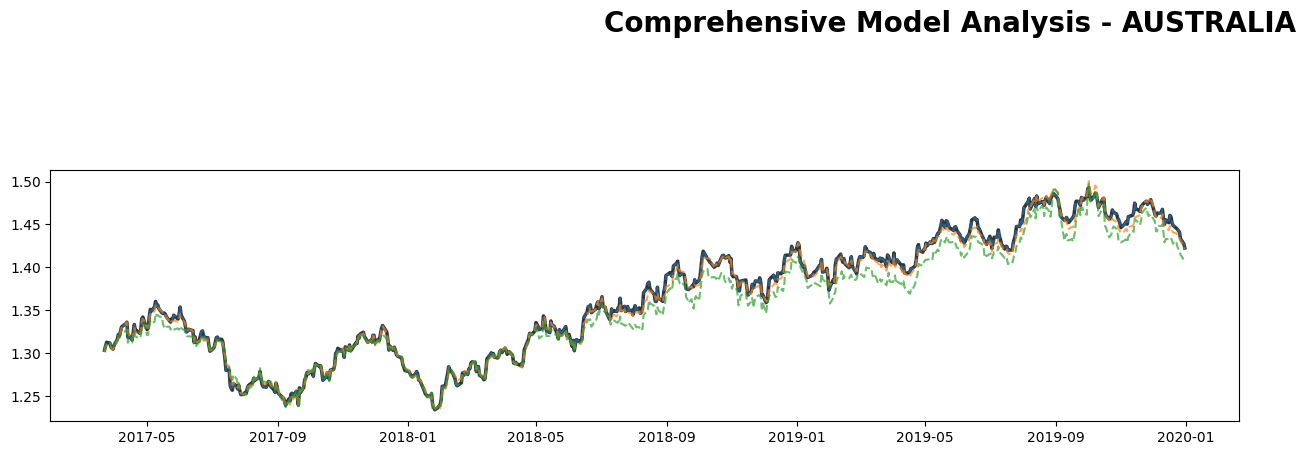

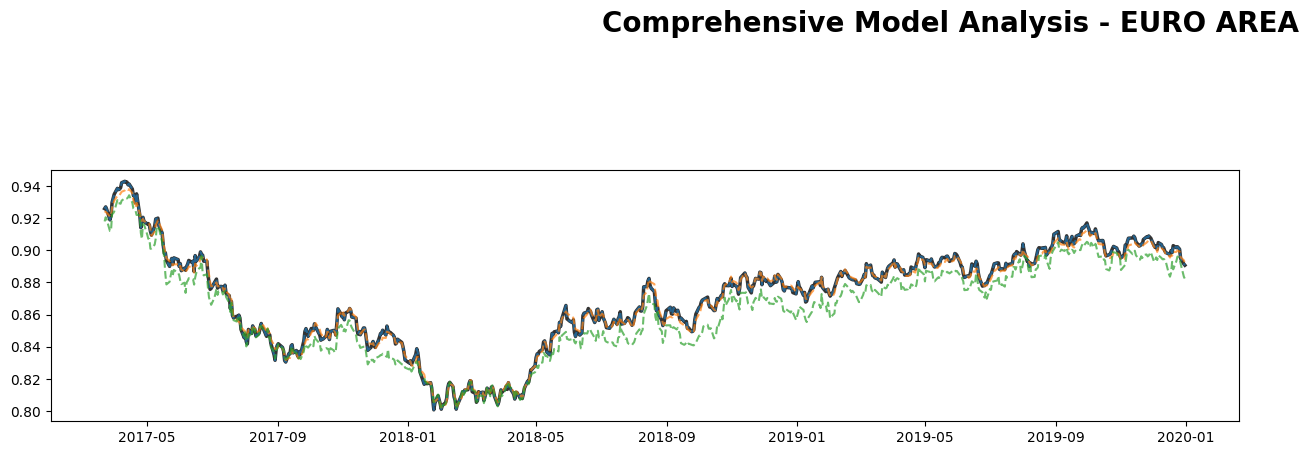

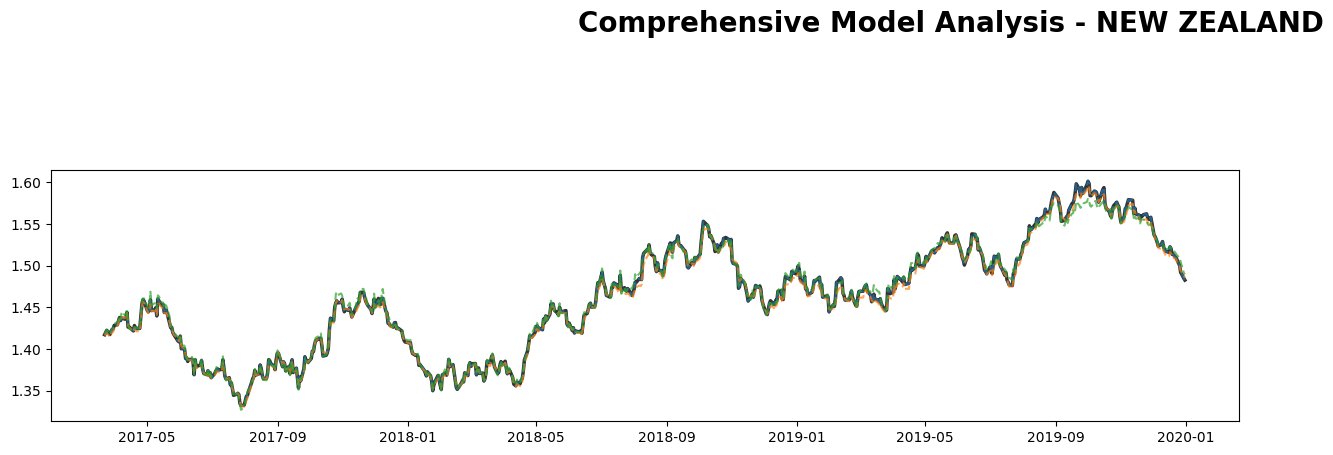

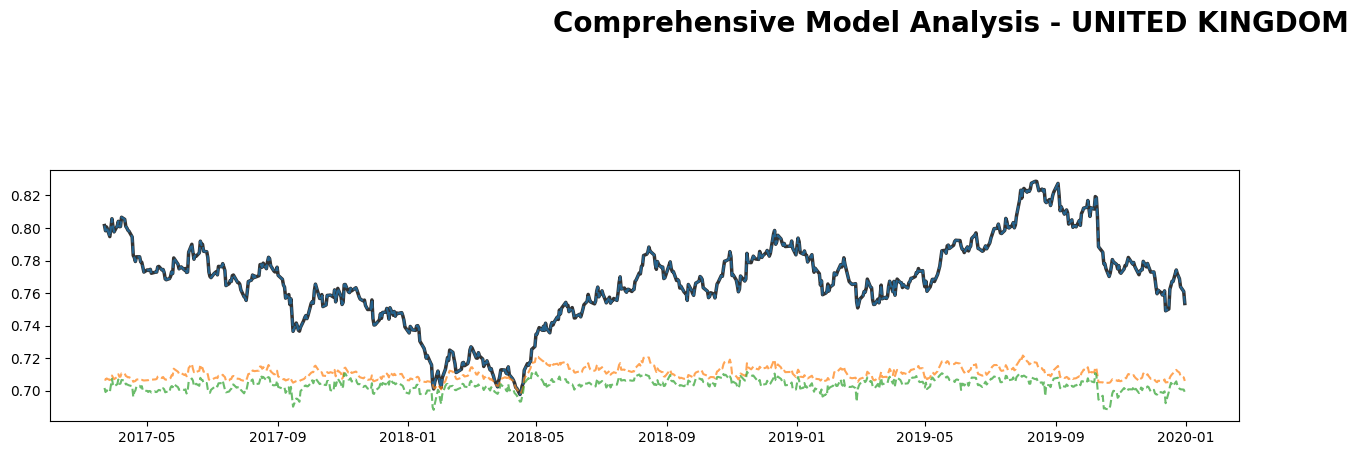

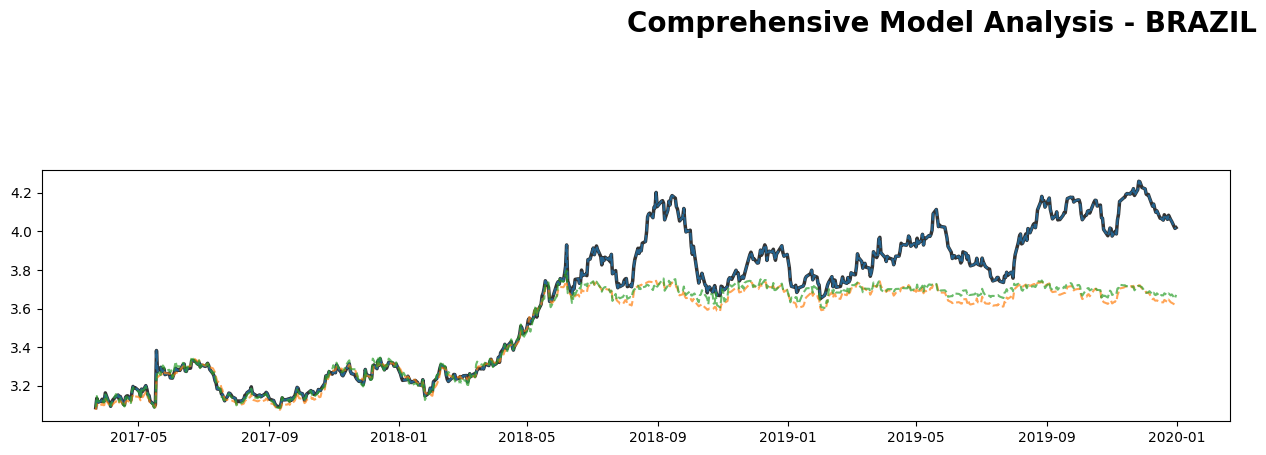

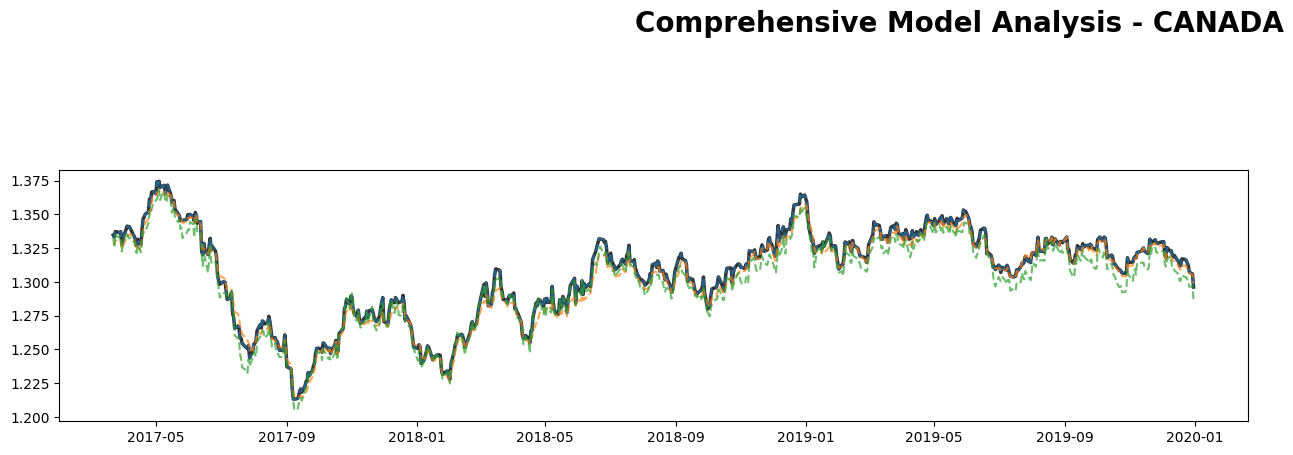

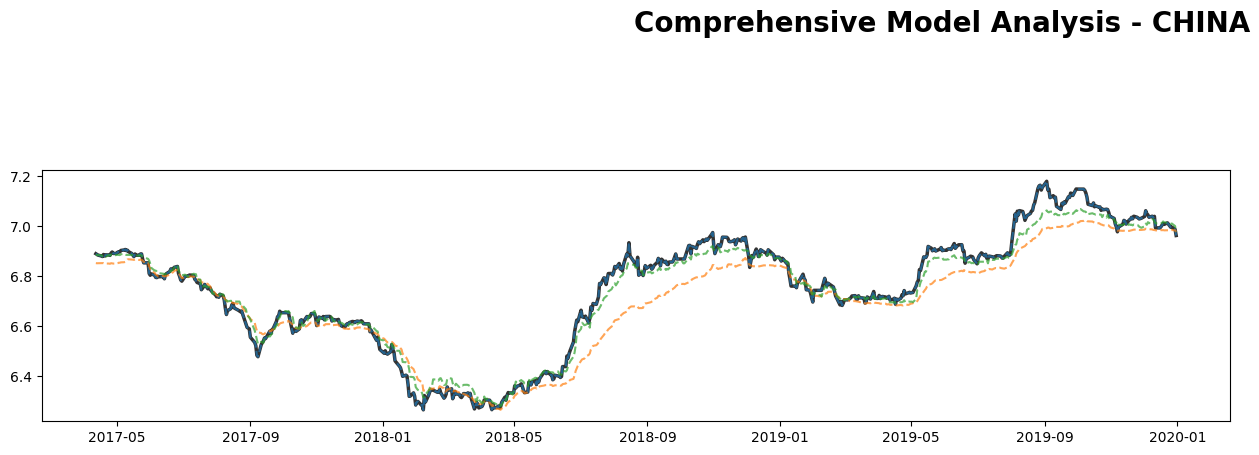

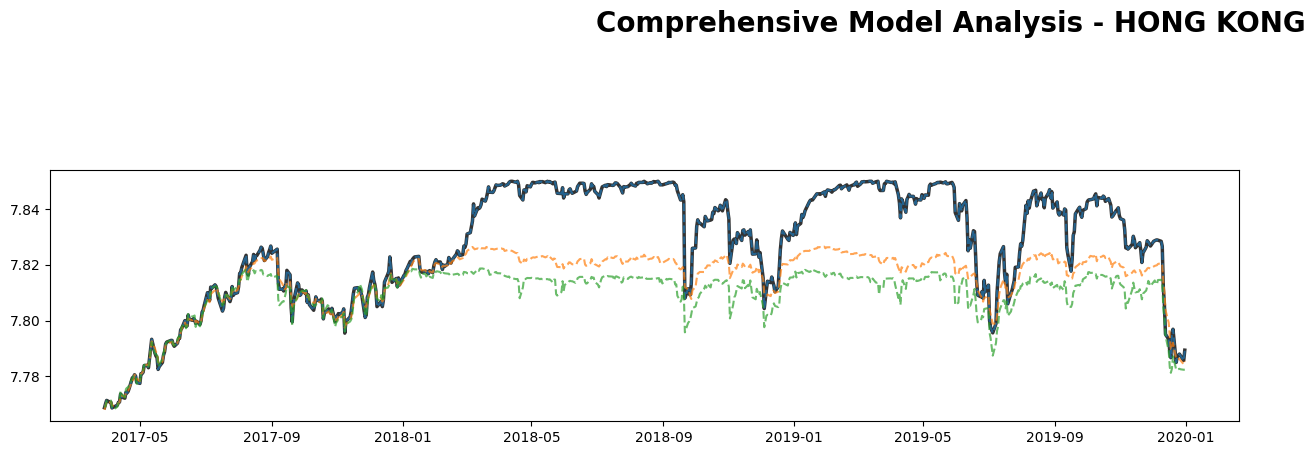

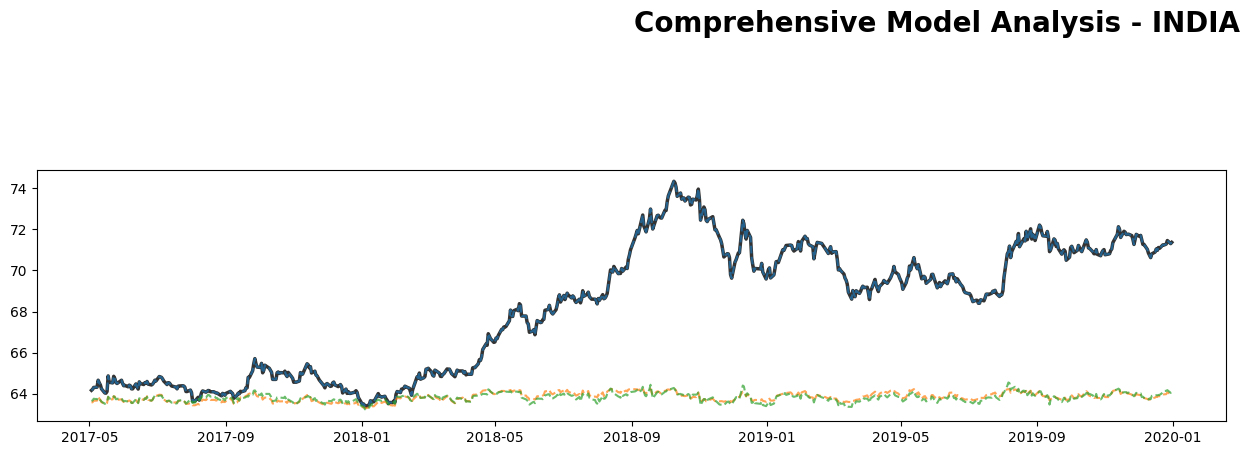

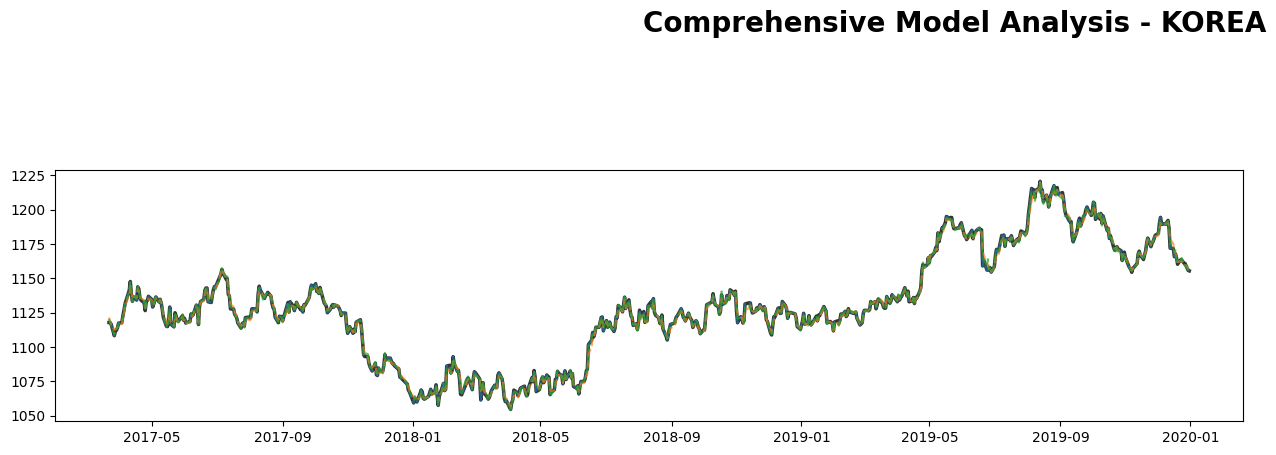

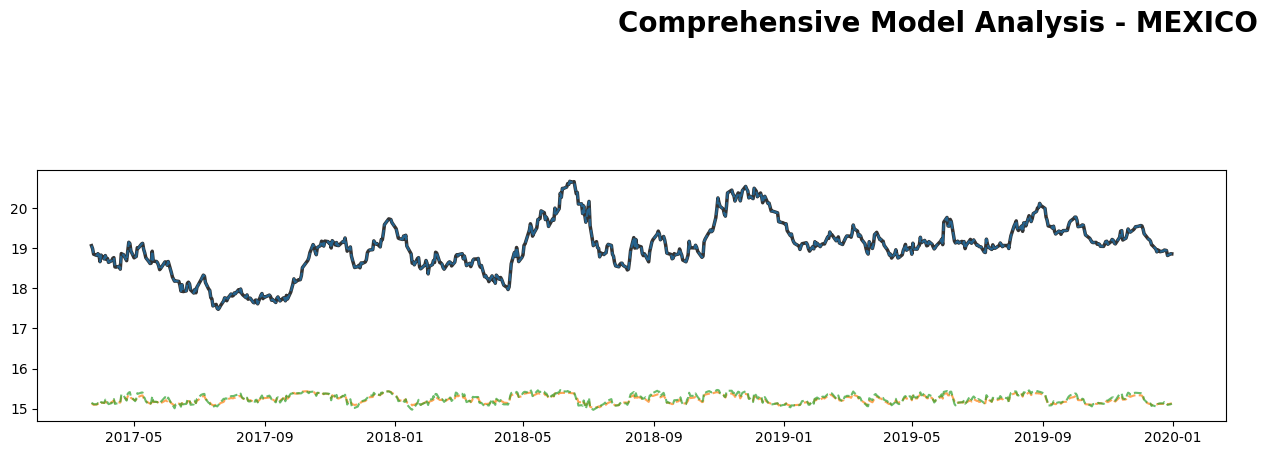

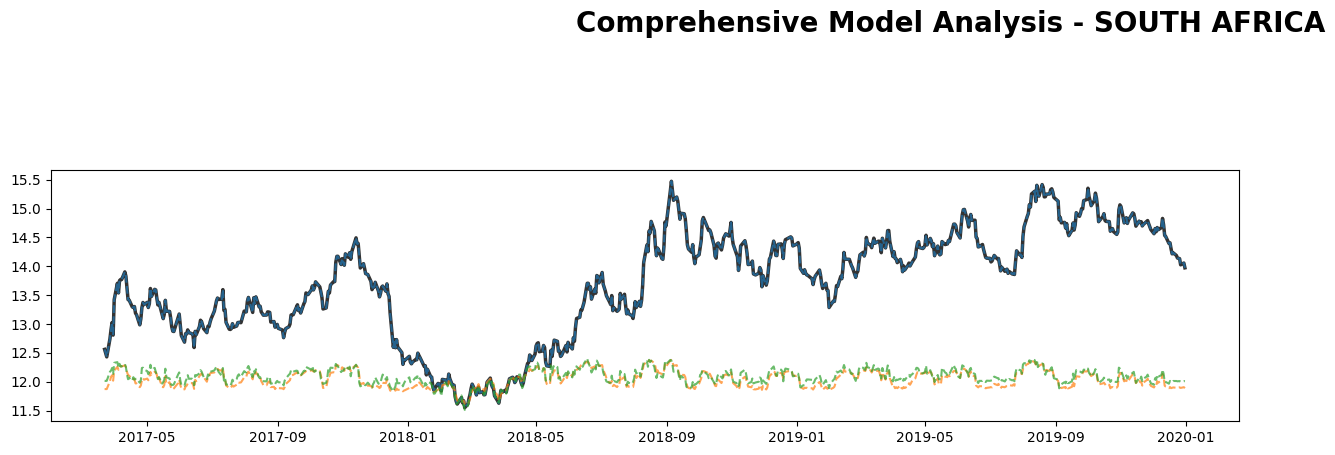

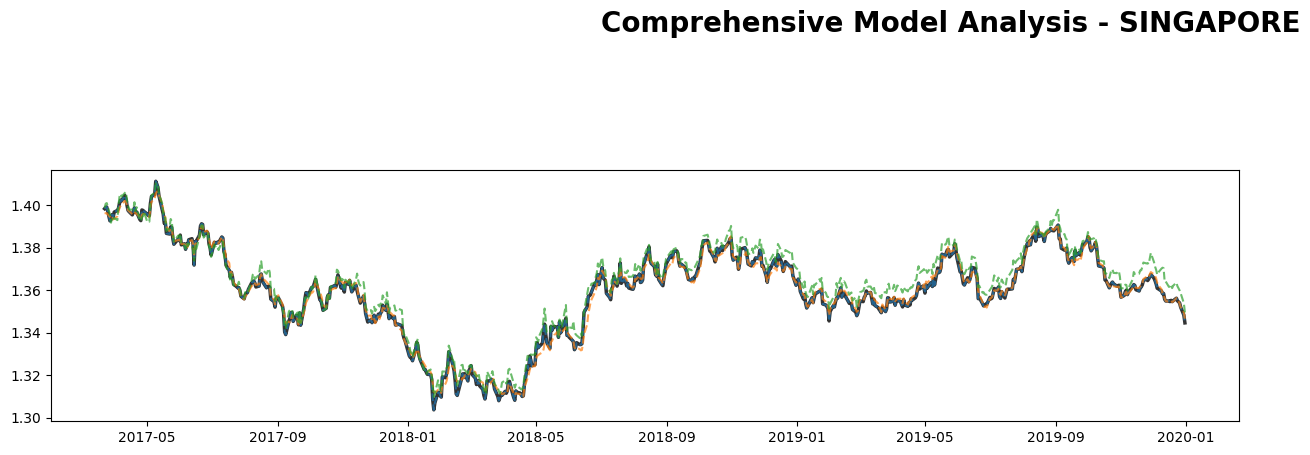

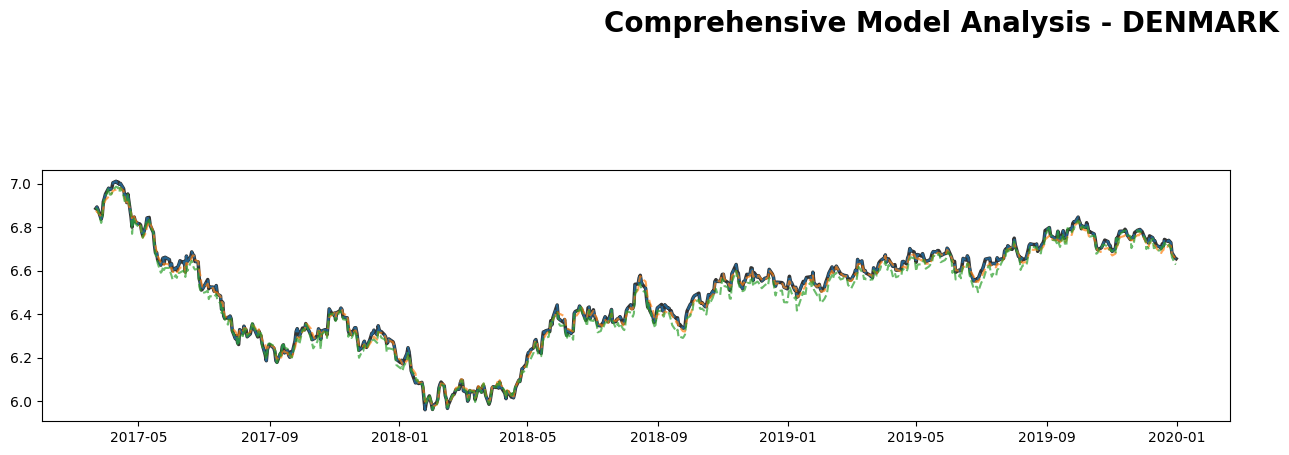

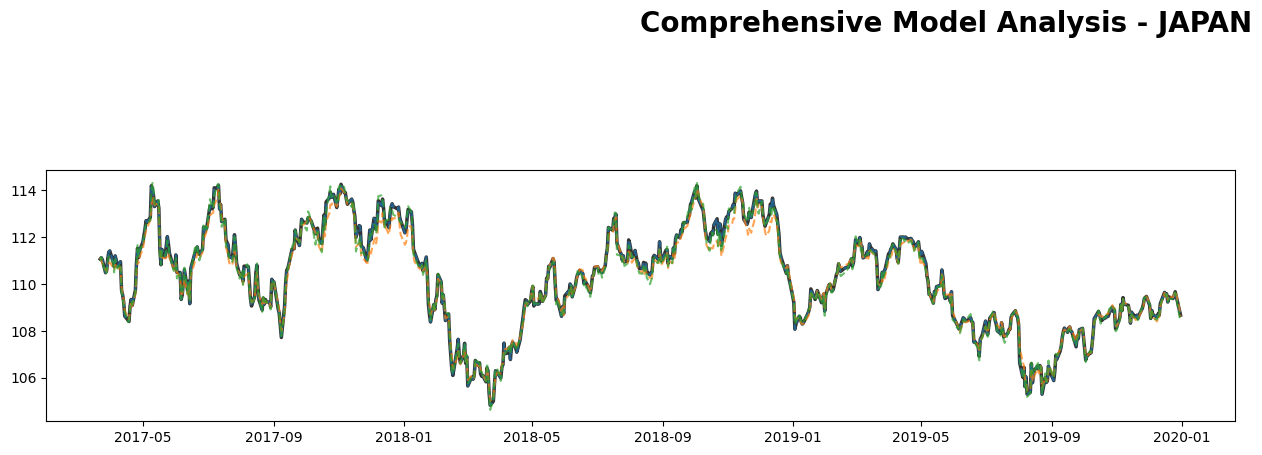

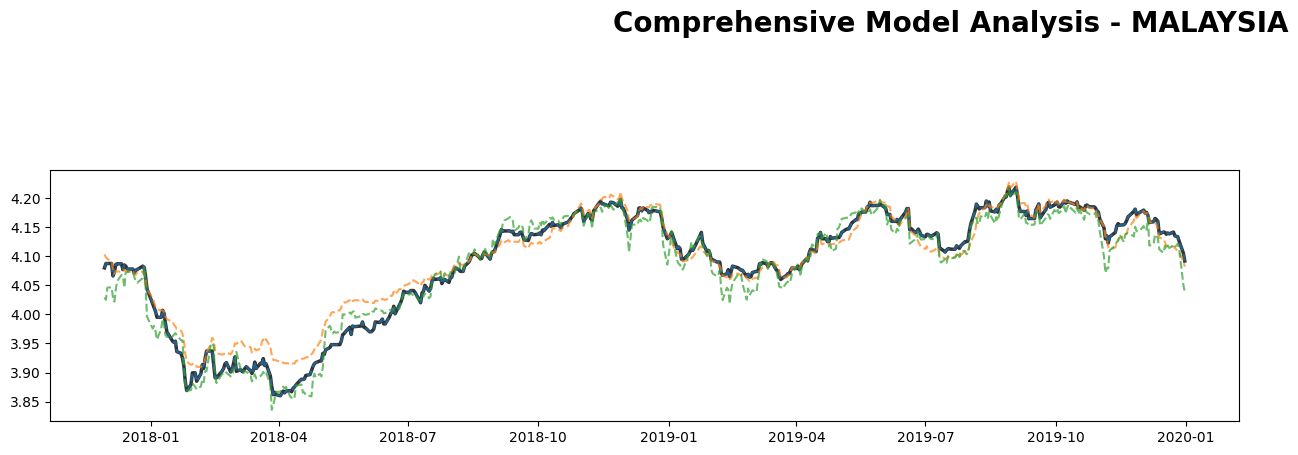

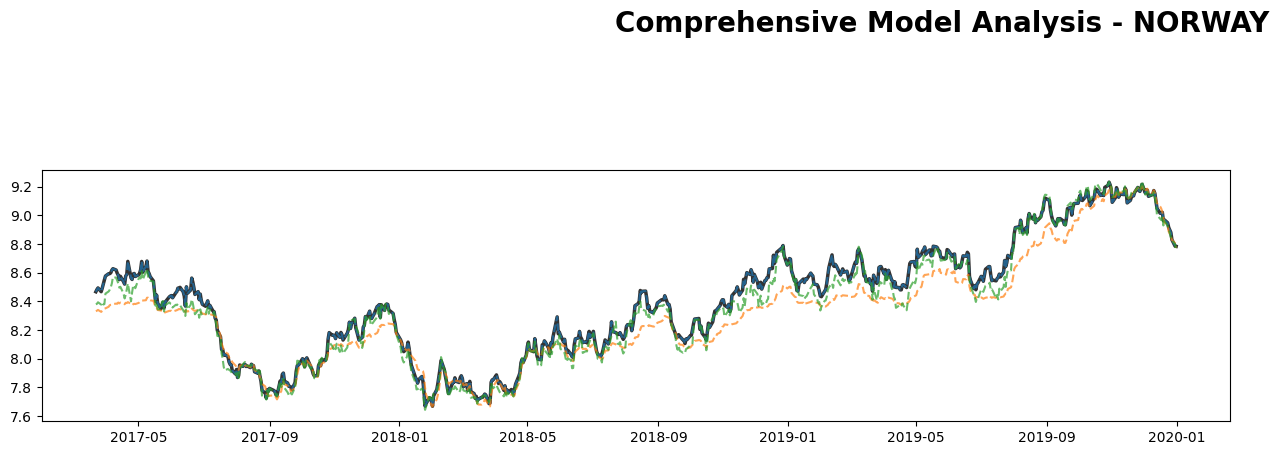

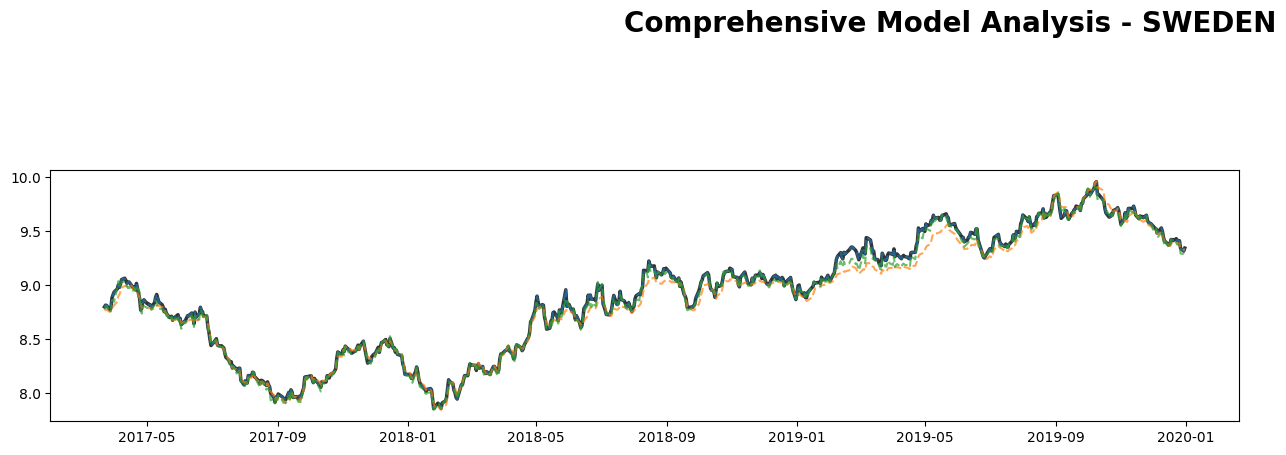

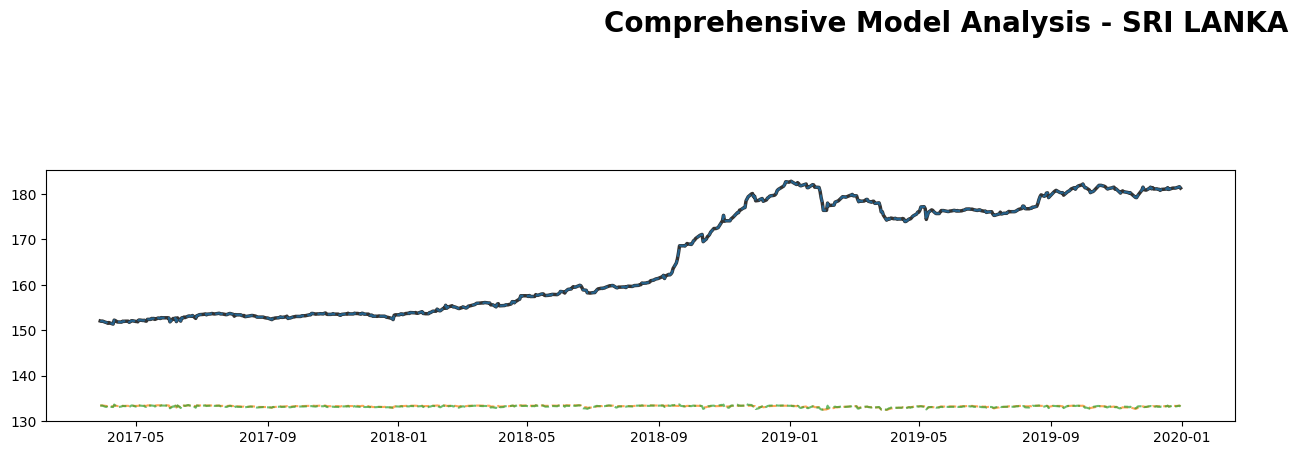

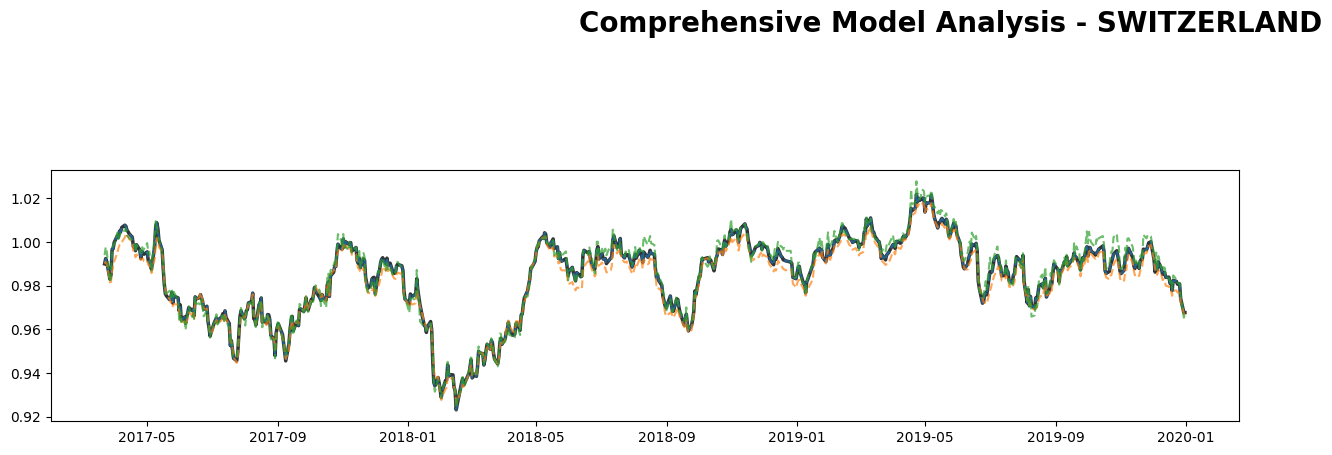

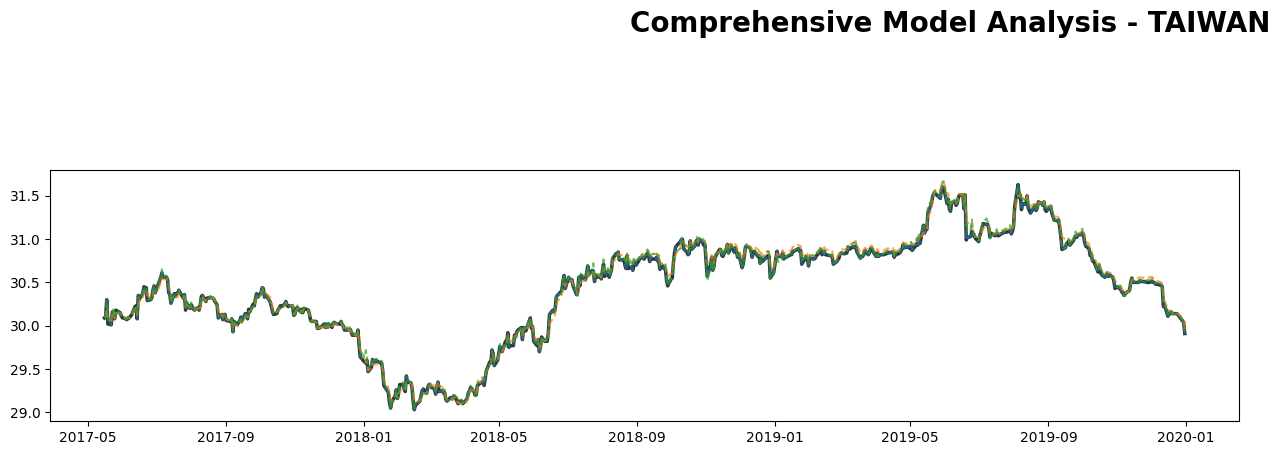

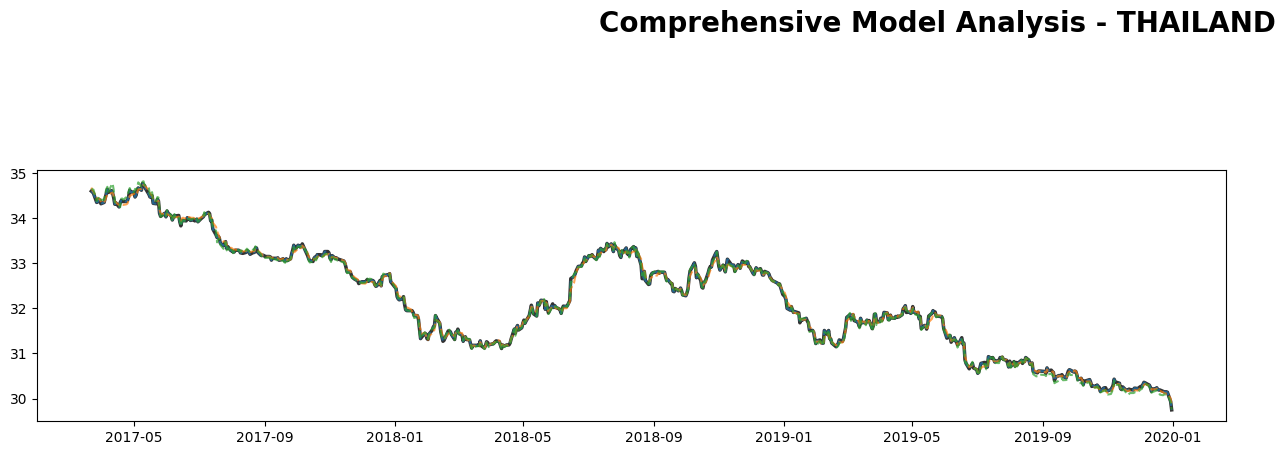

In [11]:
#Training Execution 
import time
import os

print("🎯 INITIALIZING FULL-SCALE FOREX PREDICTION SYSTEM")
print("=" * 80)
print(f"📊 Dataset: {len(forex_data)} rows, {len(forex_data.columns)} currencies")
print(f"📅 Period: {forex_data.index.min()} to {forex_data.index.max()}")
print(f"🔧 Features per currency: ~183 (comprehensive)")
print(f"🤖 Models per currency: 3+ (Traditional ML, LSTM, Prophet)")
print(f"⏱️ Estimated time: {len(forex_data.columns) * 3:.0f}-{len(forex_data.columns) * 8:.0f} minutes")

# Initialize training summary
training_summary = {}
failed_currencies = []
total_start_time = time.time()

# Get all currencies to train
currencies_to_train = forex_data.columns.tolist()

print(f"\n💱 Training queue: {len(currencies_to_train)} currencies")
for i, curr in enumerate(currencies_to_train[:5], 1):
   currency_name = curr.split(' - ')[0] if ' - ' in curr else curr
   print(f"   {i}. {currency_name}")
if len(currencies_to_train) > 5:
   print(f"   ... and {len(currencies_to_train) - 5} more currencies")

# Train each currency
for i, currency in enumerate(currencies_to_train, 1):
   currency_name = currency.split(' - ')[0] if ' - ' in currency else currency
   
   print(f"\n{'='*100}")
   print(f"🎯 TRAINING CURRENCY {i}/{len(currencies_to_train)}: {currency_name}")
   print(f"📊 Progress: {i/len(currencies_to_train)*100:.1f}% Complete")
   print('='*100)
   
   currency_start_time = time.time()
   
   try:
       # Phase 1: Feature Engineering
       print("🔧 Phase 1: Creating comprehensive features...")
       currency_df = create_comprehensive_features(forex_data, currency, lookback_days=120)
       
       if len(currency_df) < 500:
           print(f"⚠️ Insufficient data for {currency_name} ({len(currency_df)} rows)")
           failed_currencies.append((currency, "Insufficient data"))
           continue
       
       print(f"   ✅ Features created: {len(currency_df.columns)-1} features, {len(currency_df)} samples")
       
       # Phase 2: Initialize Predictor
       print("🤖 Phase 2: Initializing predictor...")
       predictor = FullScaleForexPredictor(currency)
       
       # Phase 3: Data Preparation
       print("📊 Phase 3: Preparing advanced dataset...")
       X_train, X_val, X_test, y_train, y_val, y_test = predictor.prepare_data_advanced(currency_df, test_size=0.15)
       
       if len(X_train) < 200:
           print(f"⚠️ Training set too small for {currency_name}")
           failed_currencies.append((currency, "Small training set"))
           continue
       
       # Phase 4: Model Training
       print("🚀 Phase 4: Training comprehensive models...")
       
       # Train traditional models
       print("   🤖 Training enhanced traditional ML models...")
       predictor.train_enhanced_traditional_models(X_train, X_val, X_test, y_train, y_val, y_test)
       
       # Train LSTM
       print("   🧠 Training advanced LSTM model...")
       predictor.train_advanced_lstm_model(currency_df, X_train, X_val, X_test, y_train, y_val, y_test)
       
       # Train Prophet
       print("   🔮 Training advanced Prophet model...")
       predictor.train_advanced_prophet_model(currency_df)
       
       # Phase 5: Model Comparison
       print("🏆 Phase 5: Comparing models and selecting champion...")
       best_model, results_df = predictor.compare_models_comprehensive()
       
       if best_model:
           # Phase 6: Visualizations
           print("📊 Phase 6: Creating comprehensive visualizations...")
           predictor.create_advanced_visualizations(X_test, y_test)
           
           # Phase 7: Save Model
           print("💾 Phase 7: Saving comprehensive model...")
           model_filename = predictor.save_comprehensive_model(best_model, currency_name)
           
           # Store results
           currency_time = time.time() - currency_start_time
           training_summary[currency] = {
               'currency_name': currency_name,
               'champion_model': best_model,
               'performance': results_df.loc[best_model].to_dict(),
               'all_models': {model: predictor.results[model]['MAPE'] for model in predictor.results.keys()},
               'model_file': model_filename,
               'feature_count': len(X_train.columns),
               'training_samples': len(X_train),
               'test_samples': len(X_test),
               'total_training_time': currency_time,
               'data_period': f"{currency_df.index.min()} to {currency_df.index.max()}"
           }
           
           print(f"✅ {currency_name} completed successfully!")
           print(f"   🏆 Champion: {best_model} (MAPE: {results_df.loc[best_model, 'MAPE']:.2f}%)")
           print(f"   ⏱️ Time: {currency_time:.1f}s")
       else:
           print(f"❌ No successful models for {currency_name}")
           failed_currencies.append((currency, "No successful models"))
   
   except Exception as e:
       currency_time = time.time() - currency_start_time
       print(f"❌ Error training {currency_name}: {str(e)}")
       print(f"   ⏱️ Time before failure: {currency_time:.1f}s")
       failed_currencies.append((currency, f"Training error: {str(e)[:50]}..."))
       continue

# Calculate totals
total_training_time = time.time() - total_start_time
successful_currencies = len(training_summary)
total_currencies = successful_currencies + len(failed_currencies)

# COMPREHENSIVE FINAL REPORT
print("\n" + "="*120)
print("🏁 COMPREHENSIVE TRAINING REPORT")
print("="*120)

print(f"\n📊 TRAINING OVERVIEW:")
print(f"   🎯 Total currencies attempted: {total_currencies}")
print(f"   ✅ Successfully trained: {successful_currencies}")
print(f"   ❌ Failed: {len(failed_currencies)}")
print(f"   📈 Success rate: {(successful_currencies/total_currencies*100 if total_currencies > 0 else 0):.1f}%")
print(f"   ⏱️ Total training time: {total_training_time/60:.1f} minutes")

if training_summary:
   print(f"\n🏆 CHAMPION MODELS PERFORMANCE:")
   print("-" * 100)
   
   performance_data = []
   for currency, info in training_summary.items():
       performance_data.append({
           'Currency': info['currency_name'],
           'Champion': info['champion_model'],
           'MAPE': info['performance']['MAPE'],
           'R²': info['performance']['R²'],
           'Time(s)': info['total_training_time']
       })
   
   import pandas as pd
   performance_df = pd.DataFrame(performance_data)
   performance_df = performance_df.sort_values('MAPE')
   print(performance_df.to_string(index=False, float_format='%.4f'))
   
   print(f"\n🥇 TOP 5 PERFORMERS:")
   top_5 = performance_df.head(5)
   for i, (_, row) in enumerate(top_5.iterrows(), 1):
       print(f"   {i}. {row['Currency']:20} | {row['Champion']:12} | MAPE: {row['MAPE']:6.2f}%")
   
   print(f"\n🤖 MODEL DISTRIBUTION:")
   model_counts = performance_df['Champion'].value_counts()
   for model, count in model_counts.items():
       percentage = (count / len(performance_df)) * 100
       print(f"   {model:15}: {count:2d} currencies ({percentage:5.1f}%)")
   
   print(f"\n📊 PERFORMANCE STATISTICS:")
   print(f"   📈 Average MAPE: {performance_df['MAPE'].mean():.2f}% (±{performance_df['MAPE'].std():.2f}%)")
   print(f"   🎯 Best MAPE: {performance_df['MAPE'].min():.2f}% ({performance_df.loc[performance_df['MAPE'].idxmin(), 'Currency']})")
   print(f"   📊 Worst MAPE: {performance_df['MAPE'].max():.2f}% ({performance_df.loc[performance_df['MAPE'].idxmax(), 'Currency']})")

if failed_currencies:
   print(f"\n❌ FAILED CURRENCIES:")
   for currency, reason in failed_currencies:
       currency_name = currency.split(' - ')[0] if ' - ' in currency else currency
       print(f"   • {currency_name}: {reason}")

print(f"\n💾 SAVED MODELS:")
print(f"   📁 Location: ./models/ directory")
print(f"   📊 Files: {successful_currencies} comprehensive model files")
print(f"   🚀 Ready for: Streamlit deployment")

print(f"\n🚀 NEXT STEPS:")
print(f"   1. 📱 Deploy with Streamlit: streamlit run app.py")
print(f"   2. 🐳 Or use Docker: docker-compose up --build")
print(f"   3. 🔮 Make predictions for any trained currency")

print(f"\n{'='*120}")
print("🎉 FULL-SCALE TRAINING COMPLETED SUCCESSFULLY!")
print("💱 Your comprehensive forex prediction system is ready!")
print("="*120)